In [947]:
import kagglehub
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, pearsonr
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, f1_score, accuracy_score, make_scorer, mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import os
import joblib
import shap
import time
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings

warnings.simplefilter("ignore")

%config IPCompleter.greedy=True


## Objectives
- We want to build an ML model to predict property prices across Portugal
- Our goal consist also of identifying the key features driving real estate valuations
- We want also to deploy the an API for real time price predictions on __residential houses__

## Deliverables
1. We conducted an EDA, first on the entire dataset, then specifically on the __residential_dataset__ that I created for Residential Buildings only
2. We ran a few statistical hypothesis test on the features from __residential_dataset__
3. We trained and tuned XGBoost regression model 
4. After that, we studied the explainability of our model with SHAP
5. Once we have our model ready, we put it into a docker FastAPI application
6. The product deployment of the applicaiton is on Google Cloud Run
7. We then then set an authentication for the API

## Loading the Dataset

In [948]:
path = kagglehub.dataset_download("luvathoms/portugal-real-estate-2024")
print("Access the dataset with this path", path)

Access the dataset with this path /Users/andriyvovchak/.cache/kagglehub/datasets/luvathoms/portugal-real-estate-2024/versions/19


## Exploring the Dataset

Let's take a look into our dataset

In [949]:
dataset = pd.read_csv("/Users/andriyvovchak/.cache/kagglehub/datasets/luvathoms/portugal-real-estate-2024/versions/19/portugal_listinigs.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,780000.00,Vila Real,Valpaços,Carrazedo de Montenegro e Curros,Farm,NC,200.00,552450.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,120.00,NaN,NaN,0.00
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,81.00,1.00,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,81.00,NaN,NaN,2.00
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,108.00,1.00,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,108.00,NaN,NaN,2.00
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.00,1.00,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,114.00,NaN,NaN,0.00
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.00,1.00,True,2nd Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,114.00,NaN,NaN,2.00


This dataset is clearly full of features and it seems that it has already many missing features and might have many duplicate rows, we have to check this carefully. 
Also, it seems that we're dealing with different types of buildings, which might require to group them and analyse them separately or to choose one segment and continue with it. 

### Dataset Features and their meaning

- **Price**: The asking price of the property in Euros.
- **District, City, Town**: The geographical location of the property.
- **Type**: The type of property (e.g., Apartment, House, Garage, Land).
- **EnergyCertificate**: The energy efficiency rating of the property, according to Portuguese energy certification standards.
- **Area Measurements**: Several columns related to the size and area of the property, including:
    - **GrossPrivateArea**: The private gross area of the property.
    - **UsableArea**: The area that can be used for living.
    - **LivingArea**: The actual livable space inside the property.
    - **LotSize**: The size of the land associated with the property.
    - **BuiltArea**: The total constructed area of the property.
- **Rooms, Bedrooms, Bathrooms, WCs**: Detailed breakdowns of the number of rooms, bedrooms, bathrooms, and water closets in the property.
- **Floor**: The floor on which the property is located.
- **Parking, Garage**: Information on parking availability and the presence of a garage.
- **Additional Features**: Whether the property includes amenities like elevators or electric car charging stations.
- **ConstructionYear**: The year the property was built.
- **PublishDate**: The date when the listing was published.

In [950]:
dataset.shape

(135536, 25)

We can find more information about the dataset with __.info()__

In [951]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135536 entries, 0 to 135535
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Price                  135236 non-null  float64
 1   District               135536 non-null  object 
 2   City                   135536 non-null  object 
 3   Town                   135534 non-null  object 
 4   Type                   135520 non-null  object 
 5   EnergyCertificate      135522 non-null  object 
 6   GrossArea              27638 non-null   float64
 7   TotalArea              127153 non-null  float64
 8   Parking                135342 non-null  float64
 9   HasParking             68215 non-null   object 
 10  Floor                  27929 non-null   object 
 11  ConstructionYear       88021 non-null   float64
 12  EnergyEfficiencyLevel  67289 non-null   object 
 13  PublishDate            29239 non-null   object 
 14  Garage                 67289 non-nul

Differentiating categorical and numerical features. 

In [952]:
x_numeric = ["Price", "GrossArea", "Parking", "ConstructionYear", 
             "TotalRooms", "NumberOfBedrooms", "NumberOfWC", 
             "LivingArea", "LotSize", "BuiltArea", "NumberOfBathrooms", "TotalArea"]

x_categorical = ["ConservationStatus", "ElectricCarsCharging", "Elevator",
                 "Garage", "PublishDate", "EnergyEfficiencyLevel",
                 "Floor", "HasParking", "EnergyCertificate",
                 "Type", "Town", "City"]

We can check some statistics on our __numeric features__ once we separated them from the categorical ones. 

In [953]:
dataset[x_numeric].describe()

,Price,GrossArea,Parking,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,TotalArea
count,135236.00,27638.00,135342.00,88021.00,73244.00,47041.00,57256.00,104952.00,39583.00,26617.00,128700.00,127153.00
mean,368137.45,2789.73,0.55,1989.30,3.23,2.67,0.43,1403.04,56369.39,3086.62,1.54,514077.99
std,3804044.27,115366.98,0.84,26.68,10.52,1.79,1.02,34745.97,5208473.72,118513.70,1.76,172293714.28
min,1.00,-7.00,0.00,1900.00,0.00,0.00,-15.00,0.00,0.00,-1.00,-13.00,-7196067.00
25%,84000.00,100.00,0.00,1973.00,2.00,2.00,0.00,80.00,258.00,104.57,0.00,91.00
50%,210000.00,164.00,0.00,1994.00,3.00,3.00,0.00,118.00,679.00,168.00,1.00,159.00
75%,395000.00,294.00,1.00,2009.00,4.00,3.00,1.00,204.00,2890.00,300.00,2.00,500.00
max,1380000000.00,12750000.00,3.00,2025.00,2751.00,21.00,59.00,5429000.00,992301000.00,12750000.00,131.00,61420071105.00


Thereare some buildings with a negative area, we can check the % of them and decide to remove them or not. 

In [954]:
negative_area = dataset[dataset["TotalArea"] <= 0]
print(f"Percentage: {(len(negative_area) / len(dataset)) * 100:.2f}%")

Percentage: 0.69%


Seems like our dataset has a huge variety in the `Price` range, also total `NumberOfBedrooms`, while it also has interesting values that require cleaning, like the min for the `NumberOfBathrooms`which is __-13.00__. Most importantly the `TotalArea`value is negative. This requires cleaning.

It seems that we have different types of properties, most likely we'll need to separate them based on the __Type__ feature. 

In [955]:
print(f"Before cleaning: {len(dataset)} rows")
dataset = dataset[dataset["TotalArea"] > 0]
print(f"After removing negative TotalArea: {len(dataset)} rows")

Before cleaning: 135536 rows
After removing negative TotalArea: 126220 rows


So, we're removing only the values with negative `TotalArea`

In [956]:
dataset.duplicated().sum()

np.int64(8304)

In [957]:
dataset.isnull().sum().sum()

np.int64(1138737)

In [958]:
duplicated_rows = dataset[dataset.duplicated(keep="first")]

In [959]:
print(f"The total number of duplicated rows is {len(duplicated_rows)}")

The total number of duplicated rows is 8304


These are duplicated, but most likely they contain many missing values in the features. 

In [960]:
duplicated_rows.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
93,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
152,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
153,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
154,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
155,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00


And this seems to confirm the hypothesis mentioned above. We can remove the duplicates and create a new dataset

In [961]:
dataset_clean = dataset.drop_duplicates(keep='first')

Check the dataset now

In [962]:
dataset_clean.shape

(117916, 25)

Have many rows have we removed?

In [963]:
rows_removed = dataset.shape[0] - dataset_clean.shape[0]
rows_removed

8304

No mistakes so far, it's the same amount as saw above. Let's see how the dataset_clean looks now!

In [964]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117916 entries, 0 to 135535
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Price                  117640 non-null  float64
 1   District               117916 non-null  object 
 2   City                   117916 non-null  object 
 3   Town                   117914 non-null  object 
 4   Type                   117914 non-null  object 
 5   EnergyCertificate      117916 non-null  object 
 6   GrossArea              25421 non-null   float64
 7   TotalArea              117916 non-null  float64
 8   Parking                117800 non-null  float64
 9   HasParking             63188 non-null   object 
 10  Floor                  25536 non-null   object 
 11  ConstructionYear       82169 non-null   float64
 12  EnergyEfficiencyLevel  54728 non-null   object 
 13  PublishDate            24403 non-null   object 
 14  Garage                 54728 non-null   o

Now that we handled the duplicates, we still have many missing values to take care of. Let's visualise the features with the most and the least missing values.

In [965]:
missing_values_percentage = (dataset_clean.isnull().sum() / len(dataset_clean.isnull())) * 100

missing_data = pd.DataFrame(
    {
        "total missing values": dataset_clean.isnull().sum(), 
        "in %": missing_values_percentage
    }
).sort_values("in %", ascending = False)

print(missing_data)

                       total missing values  in %
ConservationStatus                   100092 84.88
BuiltArea                             93657 79.43
PublishDate                           93513 79.30
GrossArea                             92495 78.44
Floor                                 92380 78.34
LotSize                               88969 75.45
NumberOfBedrooms                      74382 63.08
NumberOfWC                            70886 60.12
EnergyEfficiencyLevel                 63188 53.59
ElectricCarsCharging                  63188 53.59
Garage                                63188 53.59
HasParking                            54728 46.41
TotalRooms                            49966 42.37
ConstructionYear                      35747 30.32
LivingArea                            20797 17.64
NumberOfBathrooms                      4723  4.01
Price                                   276  0.23
Parking                                 116  0.10
Type                                      2  0.00


**Missing values reasoning**

We acknowledged tha we have many features that have missing values.

Now, we need to consider them feature by feature, for example: 
- `LotSize`, `ElectriCarsCharging`, `HasParrking`, `Elevator` and `Garage`, if these are missing, might be that there's no garage or LotSize.
- `EnergyCertificate` and `EnergyEffiencyLevel`, coud become one feature as they are pointing in the same direction.
- `NumberOfBedrooms` and `TotalRooms` are a critical missing value, as the price of a place is strongly influenced by these (domain knowledge). We might consider making them one feature, but also predict them based on the TotalArea.

Now we can start the EDA with this goal in mind: 
**identify which features to drop, and where we should do feature engineering**.

We can make this decision by starting from the property type. 

In [966]:
property_type = dataset_clean['Type'].value_counts(dropna = False)

print(property_type)

Type
Apartment              43476
House                  34490
Land                   21626
Store                   5019
Farm                    3691
Building                2389
Transfer of lease       1576
Warehouse               1332
Garage                   880
Other - Commercial       756
Office                   688
Other - Residential      553
Industrial               394
Duplex                   362
Investment               219
Storage                  152
Hotel                    149
Studio                    65
Estate                    58
Mansion                   33
Manor                      6
NaN                        2
Name: count, dtype: int64


**Critical Consideration on the Property Type**

Apartment, Storage, Warehouse and Farm, are completely different types of real estate and they require to be considered in different ways in different analysis. 

First of all, if it's a Warehouse, the number of rooms becomes irrelevant. 
If it's a land, then it won't have any rooms (most likely).

Second, they might have different price per square meter because they are used for different purposes. 

Third, we can't compare apples with oranges: buildings are built for different purposes and use.
In our dataset, we have different building types. We need to make a decision which ones we want to study. 
Of course, we need to first make sure they have actually different characterstics. 

In [967]:
land_property = ["Land", "Farm"]

land_dataset = dataset_clean[dataset_clean["Type"].isin(land_property)]
rooms_in_land_data = land_dataset["NumberOfBedrooms"].describe()
print(f"Rooms in land properties info:\n{rooms_in_land_data}")

Rooms in land properties info:
count   3049.00
mean       1.41
std        2.65
min        0.00
25%        0.00
50%        0.00
75%        3.00
max       21.00
Name: NumberOfBedrooms, dtype: float64


Here, we're looking into the characteristics of the `land_property`

In [968]:
commercial_properties = ["Warehouse", "Other - Commercial", "Industrial", "Office", "Store", "Building"]
commercial_dataset = dataset_clean[dataset_clean["Type"].isin(commercial_properties)]

residential_estates = ['Apartment', 'House', 'Duplex', 'Studio', 'Mansion', 'Manor', 'Oher- Residential']
residential_dataset = dataset_clean[dataset_clean['Type'].isin(residential_estates)]

In [969]:
residential_mean = residential_dataset['TotalArea'].mean()
commercial_mean = commercial_dataset['TotalArea'].mean()
land_mean = land_dataset['TotalArea'].mean()

print(f"Average sq meters in Residential estates: {residential_mean:.2f}")
print(f"Average sq meters in Commercial estates: {commercial_mean:.2f} sq meters")
print(f"Average sq meters in Land estates: {land_mean:.2f} sq meters")

Average sq meters in Residential estates: 3430.60
Average sq meters in Commercial estates: 5977.97 sq meters
Average sq meters in Land estates: 2487119.11 sq meters


Creating `PricePerSqM` to be use to compare different types of properties.

In [970]:
dataset_clean["PricePerSqM"] = np.where(
    (dataset_clean["TotalArea"] > 0 ) & dataset_clean["TotalArea"].notna() & dataset_clean["Price"].notna(), 
    dataset_clean["Price"] / dataset_clean["TotalArea"],
    np.nan
)

Now, let's plot and compare the different types of properties. 

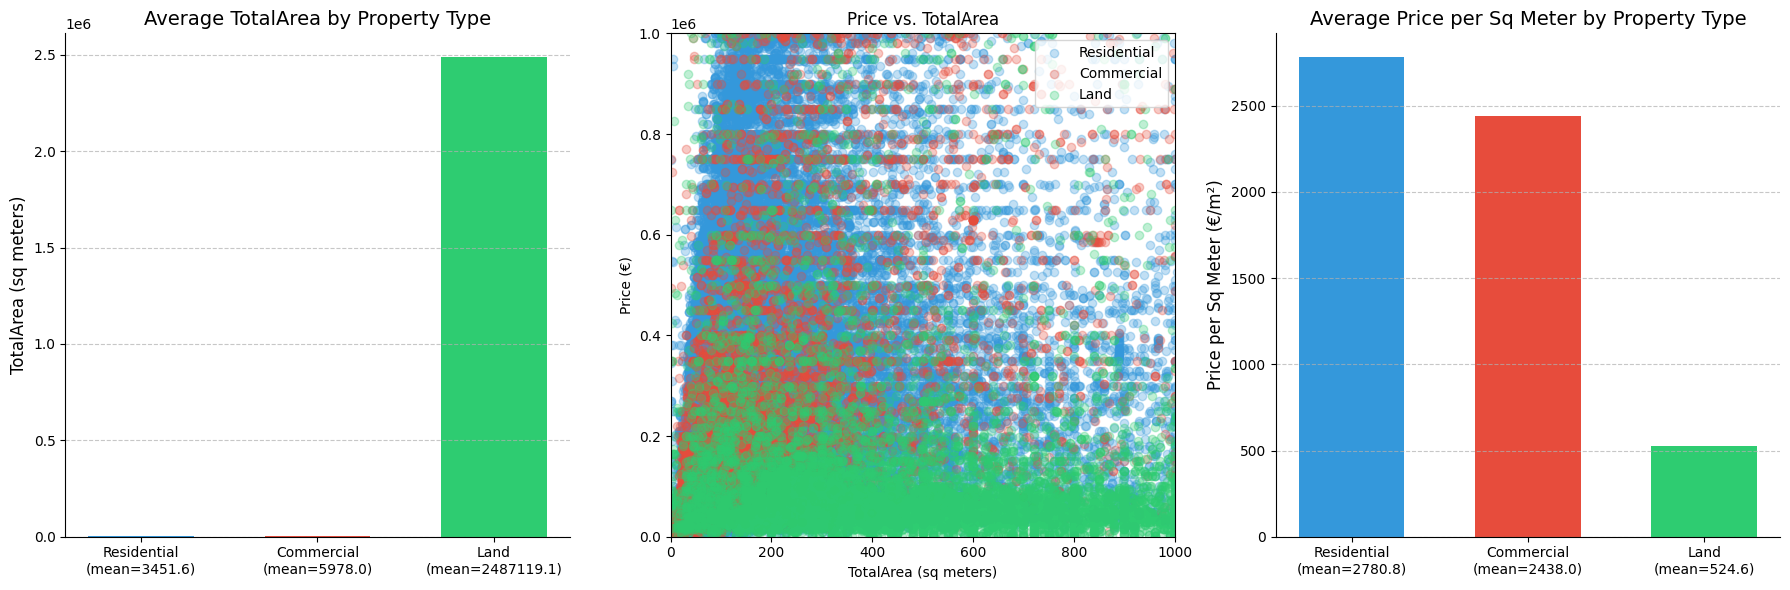

In [971]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

segments = {
    'Residential': ['Apartment', 'House', 'Duplex', 'Studio', 'Mansion', 'Manor', 'Other - Residential'],
    'Commercial': ['Warehouse', 'Other - Commercial', 'Industrial', 'Store', 'Office', 'Building'],
    'Land': ['Land', 'Farm']
}

colors = {'Residential': '#3498db', 'Commercial': '#e74c3c', 'Land': '#2ecc71'}

segment_means = []
segment_labels = []
segment_colors = []

for segment, types in segments.items():
    segment_data = dataset_clean[dataset_clean['Type'].isin(types)]
    if len(segment_data) > 0:
        mean_area = segment_data['TotalArea'].mean()
        segment_means.append(mean_area)
        segment_labels.append(f"{segment}\n(mean={mean_area:.1f})")
        segment_colors.append(colors[segment])

axes[0].bar(segment_labels, segment_means, color=segment_colors, width=0.6)
axes[0].set_title('Average TotalArea by Property Type', fontsize=14)
axes[0].set_ylabel('TotalArea (sq meters)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].spines[['top', 'right']].set_visible(False)

for segment, types in segments.items():
    segment_data = dataset_clean[dataset_clean['Type'].isin(types)]
    if len(segment_data) > 0:
        axes[1].scatter(segment_data['TotalArea'], segment_data['Price'], 
                       alpha=0.3, label=segment, c=colors[segment])
        
axes[1].set_title('Price vs. TotalArea')
axes[1].set_xlabel('TotalArea (sq meters)')
axes[1].set_ylabel('Price (€)')
axes[1].legend()
axes[1].set_xlim(0, 1000)
axes[1].set_ylim(0, 1000000)

price_means = []
price_labels = []
price_colors = []

for segment, types in segments.items():
    segment_data = dataset_clean[dataset_clean['Type'].isin(types)]
    if len(segment_data) > 0:
        mean_price = segment_data['PricePerSqM'].mean()
        price_means.append(mean_price)
        price_labels.append(f"{segment}\n(mean={mean_price:.1f})")
        price_colors.append(colors[segment])

axes[2].bar(price_labels, price_means, color=price_colors, width=0.6)
axes[2].set_title('Average Price per Sq Meter by Property Type', fontsize=14)
axes[2].set_ylabel('Price per Sq Meter (€/m²)', fontsize=12)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

#### Considerations

We can clearly see that the property types have a different `PricePerSqM` which inevitably impacts their value. 
Land cannot be compared to Residential and Commercial type of properties.
It's common sense to distinguish them and study the separately. 

In [972]:
def get_segment(property_type):
    if property_type in ["Apartment", "House", "Duplex", "Studio", "Mansion", "Manor", "Other - Residential"]:
        return "Residential"
    elif property_type in ["Warehouse", "Other - Commercial", "Industrial", "Store", "Office", "Building"]:
        return "Commercial"
    elif property_type in ["Land", "Farm"]:
        return "Land"
    else: 
        return "Other"

dataset_clean["PropertySegment"] = dataset_clean["Type"].apply(get_segment)

Now we can split data by segment: Residential, Commercial, Land and Other.
And we're going to use only __Residential, Commercial and Land__

In this case, we'll not be consider the "Other" segment, which contains: 
1. __Transfer of lease__ for a total of 1589 properties
2. __Storage__ for a total of 166 properties
3. __Hotel__ for a total of 149 properties
4. __Investment__ for a total of 222 properties
5. __Estate__ for a total of 60 properties
6. __NaN__, which represents 15 properties that are not categorised

Now we can split the data and have three different ones with different types of properties identified by `PropertySegment`

In [973]:
residential_dataset = dataset_clean[dataset_clean["PropertySegment"] == "Residential"].copy()
commercial_dataset =  dataset_clean[dataset_clean["PropertySegment"] == "Commercial"].copy()
land_dataset =  dataset_clean[dataset_clean["PropertySegment"] == "Land" ].copy()

#### Studying the fundamental differences in these datasets: residental_dataset, commercial_dataset and land_dataset

In [974]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,PricePerSqM,PropertySegment
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,81.00,1.00,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,81.00,NaN,NaN,2.00,2753.09,Residential
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,108.00,1.00,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,108.00,NaN,NaN,2.00,2111.11,Residential
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.00,1.00,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,114.00,NaN,NaN,0.00,2192.98,Residential
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.00,1.00,True,2nd Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,114.00,NaN,NaN,2.00,2192.98,Residential
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,115.00,1.00,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,115.00,NaN,NaN,2.00,2173.91,Residential


In [975]:
residential_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78985 entries, 1 to 135534
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  78761 non-null  float64
 1   District               78985 non-null  object 
 2   City                   78985 non-null  object 
 3   Town                   78985 non-null  object 
 4   Type                   78985 non-null  object 
 5   EnergyCertificate      78985 non-null  object 
 6   GrossArea              19155 non-null  float64
 7   TotalArea              78985 non-null  float64
 8   Parking                78901 non-null  float64
 9   HasParking             39670 non-null  object 
 10  Floor                  22796 non-null  object 
 11  ConstructionYear       67724 non-null  float64
 12  EnergyEfficiencyLevel  39315 non-null  object 
 13  PublishDate            19594 non-null  object 
 14  Garage                 39315 non-null  object 
 15  Elevat

In [976]:
missing_values_percentage_residential = (residential_dataset.isnull().sum() / len(residential_dataset.isnull())) * 100

missing_data_residential = pd.DataFrame(
    {
        "total missing values": residential_dataset.isnull().sum(), 
        "in %": missing_values_percentage_residential
    }
).sort_values("in %", ascending = False)

print(missing_data_residential)

                       total missing values  in %
ConservationStatus                    64314 81.43
LotSize                               61138 77.40
BuiltArea                             60327 76.38
GrossArea                             59830 75.75
PublishDate                           59391 75.19
Floor                                 56189 71.14
NumberOfWC                            45439 57.53
NumberOfBedrooms                      39826 50.42
EnergyEfficiencyLevel                 39670 50.22
Garage                                39670 50.22
ElectricCarsCharging                  39670 50.22
HasParking                            39315 49.78
TotalRooms                            20059 25.40
ConstructionYear                      11261 14.26
NumberOfBathrooms                       450  0.57
LivingArea                              279  0.35
PricePerSqM                             224  0.28
Price                                   224  0.28
Parking                                  84  0.11


In [977]:
commercial_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,PricePerSqM,PropertySegment
6,2950000.00,Faro,Albufeira,Albufeira e Olhos de Água,Building,NC,465.00,265.00,0.00,False,NaN,1998.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,406.00,NaN,NaN,0.00,11132.08,Commercial
25,320000.00,Faro,Albufeira,Albufeira e Olhos de Água,Store,C,159.00,69.00,0.00,False,NaN,1987.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,69.00,NaN,NaN,0.00,4637.68,Commercial
51,469000.00,Faro,Loulé,São Clemente,Building,E,NaN,203.00,2.00,True,NaN,1978.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,258.00,NaN,NaN,0.00,2310.34,Commercial
57,205000.00,Faro,Portimão,Portimão,Store,C,NaN,122.00,0.00,False,Ground Floor,2005.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1680.33,Commercial
59,150000.00,Faro,Faro,Faro (Sé e São Pedro),Store,B,228.00,100.00,0.00,False,Ground Floor,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,228.00,NaN,NaN,1.00,1500.00,Commercial


In [978]:
commercial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10578 entries, 6 to 135530
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  10559 non-null  float64
 1   District               10578 non-null  object 
 2   City                   10578 non-null  object 
 3   Town                   10578 non-null  object 
 4   Type                   10578 non-null  object 
 5   EnergyCertificate      10578 non-null  object 
 6   GrossArea              1937 non-null   float64
 7   TotalArea              10578 non-null  float64
 8   Parking                10573 non-null  float64
 9   HasParking             5396 non-null   object 
 10  Floor                  2089 non-null   object 
 11  ConstructionYear       7114 non-null   float64
 12  EnergyEfficiencyLevel  5182 non-null   object 
 13  PublishDate            2123 non-null   object 
 14  Garage                 5182 non-null   object 
 15  Elevat

In [979]:
missing_values_percentage_commercial = (commercial_dataset.isnull().sum() / len(commercial_dataset)) * 100

missing_data_commercial = pd.DataFrame(
    {
        "total missing values": commercial_dataset.isnull().sum(),  # ✓ Fixed!
        "in %": missing_values_percentage_commercial
    }
).sort_values("in %", ascending=False)

print(missing_data_commercial)

                       total missing values  in %
NumberOfBedrooms                       9464 89.47
ConservationStatus                     8917 84.30
BuiltArea                              8666 81.92
GrossArea                              8641 81.69
Floor                                  8489 80.25
PublishDate                            8455 79.93
LotSize                                8425 79.65
TotalRooms                             7699 72.78
NumberOfWC                             6067 57.35
EnergyEfficiencyLevel                  5396 51.01
Garage                                 5396 51.01
ElectricCarsCharging                   5396 51.01
HasParking                             5182 48.99
LivingArea                             4049 38.28
ConstructionYear                       3464 32.75
NumberOfBathrooms                       935  8.84
PricePerSqM                              19  0.18
Price                                    19  0.18
Parking                                   5  0.05


In [980]:
land_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,PricePerSqM,PropertySegment
0,780000.00,Vila Real,Valpaços,Carrazedo de Montenegro e Curros,Farm,NC,200.00,552450.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,120.00,NaN,NaN,0.00,1.41,Land
7,165000.00,Faro,Castro Marim,Altura,Land,NC,NaN,960.00,3.00,True,NaN,2023.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,171.88,Land
13,75000.00,Faro,Olhão,Moncarapacho e Fuseta,Land,NC,NaN,760.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,760.00,NaN,NaN,0.00,98.68,Land
34,18500000.00,Faro,Faro,Faro (Sé e São Pedro),Land,D,NaN,45400.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,407.49,Land
40,320000.00,Leiria,Peniche,Peniche,Land,NC,0.00,3320.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,1.00,96.39,Land


In [981]:
land_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25317 entries, 0 to 135535
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  25294 non-null  float64
 1   District               25317 non-null  object 
 2   City                   25317 non-null  object 
 3   Town                   25315 non-null  object 
 4   Type                   25317 non-null  object 
 5   EnergyCertificate      25317 non-null  object 
 6   GrossArea              3854 non-null   float64
 7   TotalArea              25317 non-null  float64
 8   Parking                25294 non-null  float64
 9   HasParking             16626 non-null  object 
 10  Floor                  80 non-null     object 
 11  ConstructionYear       5854 non-null   float64
 12  EnergyEfficiencyLevel  8691 non-null   object 
 13  PublishDate            1946 non-null   object 
 14  Garage                 8691 non-null   object 
 15  Elevat

In [982]:
missing_values_percentage_land = (land_dataset.isnull().sum() / len(land_dataset.isnull())) * 100

missing_data_land = pd.DataFrame(
    {
        "total missing values": land_dataset.isnull().sum(), 
        "in %": missing_values_percentage_land
    }
).sort_values("in %", ascending = False)

print(missing_data_land)

                       total missing values  in %
Floor                                 25237 99.68
ConservationStatus                    24230 95.71
PublishDate                           23371 92.31
NumberOfBedrooms                      22268 87.96
BuiltArea                             22097 87.28
GrossArea                             21463 84.78
TotalRooms                            19737 77.96
ConstructionYear                      19463 76.88
NumberOfWC                            17626 69.62
LotSize                               16779 66.28
EnergyEfficiencyLevel                 16626 65.67
Garage                                16626 65.67
ElectricCarsCharging                  16626 65.67
LivingArea                            14869 58.73
HasParking                             8691 34.33
NumberOfBathrooms                      2921 11.54
PricePerSqM                              23  0.09
Price                                    23  0.09
Parking                                  23  0.09


The assumption is that these are fundamentally different datasets representing different buildings. 
It sounds logical, but let's see if we can prove it with statistical data. 

Here we can see plot the difference in "Price" difference between the Property Types. 

__Why this is critical?__
Because these are different real estate properties that might have different prices for different reasons. 
For example, a lot of land, might have a huge price because it's located by the sea, but a warehouse might not.   
We need to keep this in mind then: different features have different impact on the different types. 

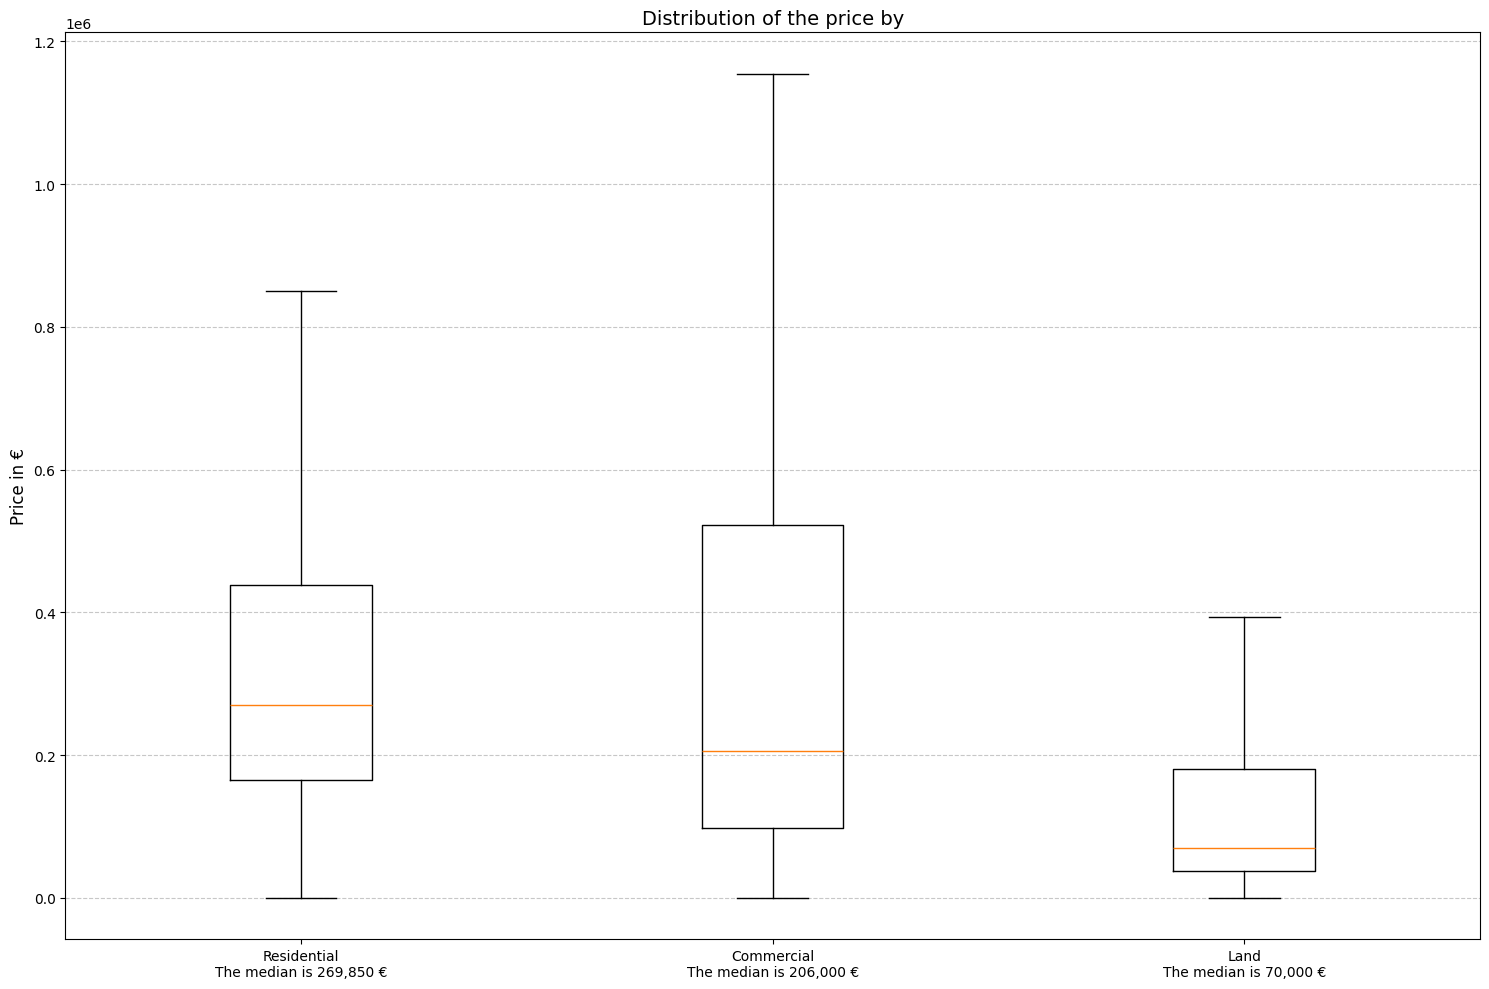

In [983]:
plt.figure(figsize=(15, 10))

data_to_plot = []
labels = []

for name, df in [('Residential', residential_dataset), ('Commercial', commercial_dataset), ('Land', land_dataset)]:
    if 'Price' in df.columns and not df['Price'].empty:
        data_to_plot.append(df['Price'].dropna())
        labels.append(f"{name}\nThe median is {df['Price'].median():,.0f} €")
plt.boxplot(data_to_plot, labels=labels, showfliers=False)
plt.title('Distribution of the price by', fontsize=14)
plt.ylabel('Price in €', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

We can clearly see that the distribution of the Residential, Commercial and Land Prices are different. 
The median values seems to be different and the IQR ranges as well. 

We can prove it with the ANOVA test. 

In [984]:
def gather_anova_groups(segment_datasets, variable):
    groups = {}
    for segment_name, df in segment_datasets.items():
        groups[segment_name] = df[variable].dropna()
    return groups

segment_datasets = {
    'Residential': residential_dataset,
    'Commercial': commercial_dataset,
    'Land': land_dataset
}

price_groups = gather_anova_groups(segment_datasets, 'Price')
price_f_stat, price_p_value = f_oneway(*price_groups.values())

print(f"F-statistic is {price_f_stat:.4f}")
print(f"p-value is {price_p_value:.10f}")
print(f"Do we have a ignificant difference between the three groups that is not due to chance? {price_p_value < 0.05}")

F-statistic is 16.7150
p-value is 0.0000000552
Do we have a ignificant difference between the three groups that is not due to chance? True


And we just confirmed it with the ANOVA test. 

#### Decision on studying residential properties only and build prediction models for them

Hereby, I decide to proceed studying only the residential property as: 
1. We have proved that the Property types have substantial difference in the % of missing values, which gives as a critical indication in the possibilities we have in studying such datasets.
3. And that they have different Features that define them. Just look at the highes % of missing values. 
4. Also, it makes logical sense differenciating them and studying them separately.
5. Choosing to study __only residenctial_dataset__ is due to personal interest.

## Studying **residential_dataset**

Since we're studying the __residential_dataset__ we can eliminate some features that might be less relevant and have high % of missing values, like: `BuiltArea`, `PublishDate`and `GrossArea`.

Also, the absence of the `LotSize`means that either there's a lot or not. 

In [985]:
residential_dataset["HasLot"] = residential_dataset["LotSize"].notna().astype(int)
residential_dataset["HasElectricCarsCharging"] = residential_dataset["ElectricCarsCharging"].notna().astype(int)
residential_dataset["HasGarage"] = residential_dataset["Garage"].notna().astype(int)
residential_dataset["HasElevator"] = residential_dataset["Elevator"].notna().astype(int)

columns_to_drop = ["BuiltArea", "PublishDate", "GrossArea", "EnergyEfficiencyLevel", "ConservationStatus", 
                   "Garage", "ElectricCarsCharging", "LotSize", "Elevator"]

residential_dataset = residential_dataset.drop(columns=columns_to_drop)

Looking at how the dataset looks now. 

In [986]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,Parking,HasParking,Floor,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasGarage,HasElevator
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,1.00,True,Ground Floor,NaN,2.00,NaN,NaN,81.00,2.00,2753.09,Residential,0,0,0,1
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,1.00,True,Ground Floor,NaN,2.00,NaN,NaN,108.00,2.00,2111.11,Residential,0,0,0,1
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,1.00,True,1st Floor,NaN,2.00,NaN,NaN,114.00,0.00,2192.98,Residential,0,0,0,1
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,1.00,True,2nd Floor,NaN,2.00,NaN,NaN,114.00,2.00,2192.98,Residential,0,0,0,1
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,1.00,True,1st Floor,NaN,2.00,NaN,NaN,115.00,2.00,2173.91,Residential,0,0,0,1


In [987]:
residential_dataset['HasCarPlace'] = ((residential_dataset['Parking'] > 0) | 
                                     (residential_dataset['HasGarage'] == 1) | 
                                     (residential_dataset['HasParking'] == True)).astype(int)

print(residential_dataset['HasCarPlace'].value_counts())

residential_dataset = residential_dataset.drop(columns=['Parking', 'HasGarage', 'HasParking'])

HasCarPlace
1    64531
0    14454
Name: count, dtype: int64


We transformed groupped the information on the possibility to park the car in a parking place with `HasCarPlace` and dropped the other columns (features).

In [988]:
residential_dataset.shape

(78985, 20)

In [989]:
floor_counts = residential_dataset["Floor"].value_counts(dropna=False)
print(floor_counts)

Floor
NaN                 56189
1st Floor            5237
Ground Floor         4483
2nd Floor            4482
3rd Floor            3452
4th Floor            1715
5th Floor            1041
6th Floor             594
7th Floor             385
Basement Level        375
Above 10th Floor      286
8th Floor             283
9th Floor             156
Duplex                147
Top Floor              85
Basement               39
Triplex                22
Attic                   9
Mezzanine               3
Service Floor           2
Name: count, dtype: int64


In [990]:
no_floor_info = (residential_dataset['Floor'].isna().sum() / len(residential_dataset)) * 100
print(f"This is the percentage of residential buildings with no info on the floors {no_floor_info:,.2f} %")

This is the percentage of residential buildings with no info on the floors 71.14 %


We can do feature engineering on the `Floor`feature and group together some of them.

In [991]:
def floor_categorisation(floor_value): 
    floor_string = str(floor_value).lower()

    if 'ground' in floor_string or 'basement' in floor_string or 'service' in floor_string:
        return 'Ground Floor'
    elif '1st' in floor_string or 'mezzanine' in floor_string:
        return 'Low - 1st'
    elif any(floor in floor_string for floor in ['2nd', '3rd', '4th', '5h']):
        return 'Mid 2nd-5th'
    elif any(floor in floor_string for floor in ['6th', '7th', '8th', '9th']) or 'top' in floor_string:
        return 'High 6th-9th'
    elif 'above 10th' in floor_string:
        return 'Very High 10+'
    elif 'duplex' in floor_string or 'triplex' in floor_string:
        return 'Multi-Level'
    elif 'attic' in floor_string:
        return 'Attic'
    else:
        return 'Other'

residential_dataset['FloorSegment'] = residential_dataset['Floor'].apply(floor_categorisation)
residential_dataset['HasFloorInfo'] = residential_dataset['Floor'].notna().astype(int)
residential_dataset = residential_dataset.drop(columns=['Floor'])

In [992]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,NaN,2.00,NaN,NaN,81.00,2.00,2753.09,Residential,0,0,1,1,Ground Floor,1
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,NaN,2.00,NaN,NaN,108.00,2.00,2111.11,Residential,0,0,1,1,Ground Floor,1
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,2.00,NaN,NaN,114.00,0.00,2192.98,Residential,0,0,1,1,Low - 1st,1
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,2.00,NaN,NaN,114.00,2.00,2192.98,Residential,0,0,1,1,Mid 2nd-5th,1
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,NaN,2.00,NaN,NaN,115.00,2.00,2173.91,Residential,0,0,1,1,Low - 1st,1


We see that we have two features that are really similar to each other: `NumberOfBathrooms`and `NumberOfWC`, so we can group them.

In [993]:
residential_dataset['TotalRestrooms'] = residential_dataset['NumberOfBathrooms'].fillna(0) + residential_dataset['NumberOfWC'].fillna(0)

both_missing_mask = residential_dataset['NumberOfBathrooms'].isna() & residential_dataset['NumberOfWC'].isna()
residential_dataset.loc[both_missing_mask, 'TotalRestrooms'] = np.nan

In [994]:
print("Ok, let's see the statistics for TotalRestrooms now:")
print(residential_dataset['TotalRestrooms'].describe())

missing_pct = residential_dataset['TotalRestrooms'].isna().mean() * 100
print(f"TotalRestrooms missing: {missing_pct:.2f}%")

Ok, let's see the statistics for TotalRestrooms now:
count   78535.00
mean        2.29
std         1.85
min       -28.00
25%         1.00
50%         2.00
75%         3.00
max       132.00
Name: TotalRestrooms, dtype: float64
TotalRestrooms missing: 0.57%


Clearly, we need to clean the info in this feature as, we can't have negative values for the `TotalRestrooms`

In [995]:
negative_restrooms = residential_dataset[residential_dataset['TotalRestrooms'] < 0]
negative_restrooms

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo,TotalRestrooms
11036,180000.00,Leiria,Pombal,Santiago e São Simão de Litém e Albergaria dos...,House,B-,1122.00,2011.00,2.00,NaN,NaN,90.00,-1.00,160.43,Residential,0,0,1,0,Other,0,-1.00
38614,1250000.00,Lisboa,Lisboa,Avenidas Novas,Apartment,NC,133.00,NaN,2.00,NaN,NaN,127.00,-13.00,9398.50,Residential,0,0,1,1,Mid 2nd-5th,1,-13.00
94967,1250000.00,Lisboa,Lisboa,Avenidas Novas,Apartment,NC,133.00,NaN,3.00,2.00,-15.00,127.00,-13.00,9398.50,Residential,0,1,1,1,Other,0,-28.00


We can consider the negative values as a type for the bathrooms and/or NumberOfWC

In [996]:
residential_dataset = residential_dataset[residential_dataset['TotalRestrooms'] >= 0]
residential_dataset = residential_dataset.drop(columns=['NumberOfBathrooms', 'NumberOfWC'])
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,ConstructionYear,TotalRooms,NumberOfBedrooms,LivingArea,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo,TotalRestrooms
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,NaN,2.00,NaN,81.00,2753.09,Residential,0,0,1,1,Ground Floor,1,2.00
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,NaN,2.00,NaN,108.00,2111.11,Residential,0,0,1,1,Ground Floor,1,2.00
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,2.00,NaN,114.00,2192.98,Residential,0,0,1,1,Low - 1st,1,0.00
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,2.00,NaN,114.00,2192.98,Residential,0,0,1,1,Mid 2nd-5th,1,2.00
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,NaN,2.00,NaN,115.00,2173.91,Residential,0,0,1,1,Low - 1st,1,2.00


Now we want to apply the same logic for the `TotalRooms`and the `NumberOfBedrooms`. 

We're following this logic:
If both missing then we get NaN 
If only TotalRooms is  available, then we use that one
If only Bedrooms is available, then we use it
If both are available we use the maximum of the two

In [997]:
def calculate_total_living_spaces(row):
    total_rooms = row['TotalRooms']
    bedrooms = row['NumberOfBedrooms']
    
    total_rooms = 0 if pd.isna(total_rooms) else max(0, total_rooms) 
    bedrooms = 0 if pd.isna(bedrooms) else max(0, bedrooms)  
    
   
    if pd.isna(row['TotalRooms']) and pd.isna(row['NumberOfBedrooms']):
        return np.nan
        
    
    if not pd.isna(row['TotalRooms']) and pd.isna(row['NumberOfBedrooms']):
        return total_rooms
    
    if pd.isna(row['TotalRooms']) and not pd.isna(row['NumberOfBedrooms']):
        return bedrooms
    
    if total_rooms >= bedrooms:
        return total_rooms  
    else:
        return bedrooms  
    
residential_dataset['TotalLivingSpaces'] = residential_dataset.apply(calculate_total_living_spaces, axis=1)
residential_dataset = residential_dataset.drop(columns=['TotalRooms', 'NumberOfBedrooms'])

In [998]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,ConstructionYear,LivingArea,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo,TotalRestrooms,TotalLivingSpaces
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,NaN,81.00,2753.09,Residential,0,0,1,1,Ground Floor,1,2.00,2.00
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,NaN,108.00,2111.11,Residential,0,0,1,1,Ground Floor,1,2.00,2.00
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,114.00,2192.98,Residential,0,0,1,1,Low - 1st,1,0.00,2.00
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,114.00,2192.98,Residential,0,0,1,1,Mid 2nd-5th,1,2.00,2.00
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,NaN,115.00,2173.91,Residential,0,0,1,1,Low - 1st,1,2.00,2.00


We see that `ConstructionYear` has many different values, which might create problems during encoding. Therefore, we can group these values. 

In [999]:
construction_year = residential_dataset["ConstructionYear"].value_counts(dropna=False)
print(construction_year)

ConstructionYear
NaN        11179
2023.00     4669
2024.00     4027
1937.00     3924
1951.00     2778
           ...  
1919.00        3
1906.00        2
1909.00        2
1907.00        1
1903.00        1
Name: count, Length: 122, dtype: int64


In [1000]:
def categorize_construction_year(year):
    if pd.isna(year):
        return "Unknown"
    
    if year < 1950:
        return "Vintage (pre-1950)"
    elif year < 1990:
        return "Old (1950-1989)"
    elif year < 2010:
        return "Mid-age (1990-2009)"
    elif year < 2020:
        return "Recent (2010-2019)"
    else:
        return "Brand New (2020+)"

residential_dataset['BuildingAge'] = residential_dataset['ConstructionYear'].apply(categorize_construction_year)
residential_dataset['BuildingAge'].describe()

count               78532
unique                  6
top       Old (1950-1989)
freq                23428
Name: BuildingAge, dtype: object

In [1001]:
print(residential_dataset['ConstructionYear'].isna().sum())

11179


As we have many missing values, we want to use `impute` them. 
To do so, we're going to use some features, but not all of them: most likely, District, the building type, the Energy Certificate and the Floor segment could help figuring out the construction year. 

Why? 
Energy Certificate -> the higher the new is the apartment
Also, specific districts are usually populated with new buildings or old buildings. 
Same logic applies to building type and floor segment (at which floor is the real estate)

In [1002]:
year_data = residential_dataset[residential_dataset['ConstructionYear'].notna()].copy()

categorical_predictors = ['District', 'Type', 'EnergyCertificate', 'FloorSegment']

print("ANOVA test for categorical variables:")
for categorical_variable in categorical_predictors:
    if categorical_variable in year_data.columns:

        groups = year_data.groupby(categorical_variable)['ConstructionYear'].apply(list)  

        if min(groups.apply(len)) < 5:
            print(f"{categorical_variable}: Insufficient data in some groups") 
            continue

        f_value, p_value = stats.f_oneway(*groups)
        print(f"{categorical_variable}: F={f_value:.2f}, p={p_value:.6f}")

ANOVA test for categorical variables:
District: Insufficient data in some groups
Type: Insufficient data in some groups
EnergyCertificate: F=2453.19, p=0.000000
FloorSegment: F=108.41, p=0.000000


Seems like District and Type don't have enough data for this imputation. 
Properties with different energy certificates were built in very different periods (it seems!). 
Also, floor segment correlates with construction year, but we can use it as proxy as well in support of the Energy Certificate.


This is the logic, we use for the imputation:
Is the `ConstructionYear` missing? Then I use the median year of properties with same energy certificate (A+ → recent, G → old)
Still, we can't do this imputation? Then we use the total median.

In [1003]:
def impute_construction_year(row):
    if pd.notna(row['ConstructionYear']):
        return row['ConstructionYear']
    
    cert_year_medians = residential_dataset.groupby('EnergyCertificate')['ConstructionYear'].median()
    
    cert = row['EnergyCertificate']
    if cert in cert_year_medians and pd.notna(cert_year_medians[cert]):
        return cert_year_medians[cert]
    
    return residential_dataset['ConstructionYear'].median()

residential_dataset['ConstructionYear_Imputed'] = residential_dataset.apply(impute_construction_year, axis=1)

residential_dataset['YearImputed'] = residential_dataset['ConstructionYear'].isna().astype(int)

residential_dataset['BuildingAge'] = residential_dataset['ConstructionYear_Imputed'].apply(categorize_construction_year)

In [1004]:
residential_dataset = residential_dataset.drop(columns = ['ConstructionYear'])

print(residential_dataset['BuildingAge'].value_counts())

BuildingAge
Old (1950-1989)        28888
Mid-age (1990-2009)    21902
Brand New (2020+)      17959
Vintage (pre-1950)      5728
Recent (2010-2019)      4055
Name: count, dtype: int64


Now the `ConstructionYear`became the `BuildingAge`

In [1005]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,LivingArea,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo,TotalRestrooms,TotalLivingSpaces,BuildingAge,ConstructionYear_Imputed,YearImputed
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,81.00,2753.09,Residential,0,0,1,1,Ground Floor,1,2.00,2.00,Brand New (2020+),2023.00,1
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,108.00,2111.11,Residential,0,0,1,1,Ground Floor,1,2.00,2.00,Brand New (2020+),2023.00,1
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,114.00,2192.98,Residential,0,0,1,1,Low - 1st,1,0.00,2.00,Brand New (2020+),2023.00,1
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,114.00,2192.98,Residential,0,0,1,1,Mid 2nd-5th,1,2.00,2.00,Brand New (2020+),2023.00,1
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,115.00,2173.91,Residential,0,0,1,1,Low - 1st,1,2.00,2.00,Brand New (2020+),2023.00,1


In [1006]:
residential_dataset.shape

(78532, 21)

In [1007]:
residential_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78532 entries, 1 to 135534
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     78308 non-null  float64
 1   District                  78532 non-null  object 
 2   City                      78532 non-null  object 
 3   Town                      78532 non-null  object 
 4   Type                      78532 non-null  object 
 5   EnergyCertificate         78532 non-null  object 
 6   TotalArea                 78532 non-null  float64
 7   LivingArea                78281 non-null  float64
 8   PricePerSqM               78308 non-null  float64
 9   PropertySegment           78532 non-null  object 
 10  HasLot                    78532 non-null  int64  
 11  HasElectricCarsCharging   78532 non-null  int64  
 12  HasElevator               78532 non-null  int64  
 13  HasCarPlace               78532 non-null  int64  
 14  FloorSegme

We still have a small % of rows without the `Price`, which is our dependent variable. We can drop them. 
We can't train a price prediction model without the target variable

In [1008]:
residential_dataset = residential_dataset.dropna(subset = ["Price"])

Still have to impute some features where we can do imputation by using the median. 

In [1009]:
residential_dataset["TotalArea"].fillna(residential_dataset["TotalArea"].median(), inplace = True)
residential_dataset["LivingArea"].fillna(residential_dataset["LivingArea"].median(), inplace = True)
residential_dataset["TotalLivingSpaces"].fillna(residential_dataset["TotalLivingSpaces"].median(), inplace=True)

In [1010]:
missing_values_in_ppsm = residential_dataset["PricePerSqM"].isna()
residential_dataset.loc[missing_values_in_ppsm, "PricePerSqM"] = np.where(
    residential_dataset.loc[missing_values_in_ppsm, "TotalArea"] > 0,
    residential_dataset.loc[missing_values_in_ppsm, "Price"] / residential_dataset.loc[missing_values_in_ppsm, "TotalArea"],
    np.nan
)

In [1011]:
residential_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78308 entries, 1 to 135534
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     78308 non-null  float64
 1   District                  78308 non-null  object 
 2   City                      78308 non-null  object 
 3   Town                      78308 non-null  object 
 4   Type                      78308 non-null  object 
 5   EnergyCertificate         78308 non-null  object 
 6   TotalArea                 78308 non-null  float64
 7   LivingArea                78308 non-null  float64
 8   PricePerSqM               78308 non-null  float64
 9   PropertySegment           78308 non-null  object 
 10  HasLot                    78308 non-null  int64  
 11  HasElectricCarsCharging   78308 non-null  int64  
 12  HasElevator               78308 non-null  int64  
 13  HasCarPlace               78308 non-null  int64  
 14  FloorSegme

Showing only info on Column Types

In [1012]:
print(residential_dataset.dtypes)

Price                       float64
District                     object
City                         object
Town                         object
Type                         object
EnergyCertificate            object
TotalArea                   float64
LivingArea                  float64
PricePerSqM                 float64
PropertySegment              object
HasLot                        int64
HasElectricCarsCharging       int64
HasElevator                   int64
HasCarPlace                   int64
FloorSegment                 object
HasFloorInfo                  int64
TotalRestrooms              float64
TotalLivingSpaces           float64
BuildingAge                  object
ConstructionYear_Imputed    float64
YearImputed                   int64
dtype: object


Any missing values?

In [1013]:
print(residential_dataset.isnull().sum())

Price                       0
District                    0
City                        0
Town                        0
Type                        0
EnergyCertificate           0
TotalArea                   0
LivingArea                  0
PricePerSqM                 0
PropertySegment             0
HasLot                      0
HasElectricCarsCharging     0
HasElevator                 0
HasCarPlace                 0
FloorSegment                0
HasFloorInfo                0
TotalRestrooms              0
TotalLivingSpaces           0
BuildingAge                 0
ConstructionYear_Imputed    0
YearImputed                 0
dtype: int64


Now we can differentiate the categorical columns from the numeric columns, also, we make a special place for the binary features. 

In [1014]:
x_categorical_residential = residential_dataset.select_dtypes( include = ['object']).columns.tolist()
print(x_categorical_residential)

['District', 'City', 'Town', 'Type', 'EnergyCertificate', 'PropertySegment', 'FloorSegment', 'BuildingAge']


In [1015]:
x_binary_residential = residential_dataset.select_dtypes(include = ['int']).columns.tolist()
print(x_binary_residential)

['HasLot', 'HasElectricCarsCharging', 'HasElevator', 'HasCarPlace', 'HasFloorInfo', 'YearImputed']


In [1016]:
x_numeric_residential = residential_dataset.select_dtypes(include = ['float']).columns.tolist()
print(x_numeric_residential)

['Price', 'TotalArea', 'LivingArea', 'PricePerSqM', 'TotalRestrooms', 'TotalLivingSpaces', 'ConstructionYear_Imputed']


In [1017]:
residential_dataset[x_numeric_residential].describe()

,Price,TotalArea,LivingArea,PricePerSqM,TotalRestrooms,TotalLivingSpaces,ConstructionYear_Imputed
count,78308.00,78308.00,78308.00,78308.00,78308.00,78308.00,78308.00
mean,409713.84,3474.52,223.20,2786.87,2.29,3.19,1992.02
std,4956183.46,336676.01,3906.40,22194.71,1.85,9.99,25.89
min,1.00,1.00,0.00,0.00,0.00,0.00,1900.00
25%,166500.00,85.00,77.00,1071.43,1.00,2.00,1979.00
50%,270000.00,124.00,108.00,2175.00,2.00,3.00,1994.00
75%,439000.00,222.00,162.00,3534.48,3.00,4.00,2014.00
max,1380000000.00,56215100.00,470300.00,5000000.00,132.00,2751.00,2025.00


## EDA for Residential Properties Price Prediction

In [1018]:
for feature in x_numeric_residential:
    print(f"{feature} and its distribution:")
    print(f"  Mean: {residential_dataset[feature].mean():.2f}")
    print(f"  Median: {residential_dataset[feature].median():.2f}")
    print(f"  25th percentile: {residential_dataset[feature].quantile(0.25):.2f}")
    print(f"  50th percentile: {residential_dataset[feature].quantile(0.50):.2f}")
    print(f"  75th percentile: {residential_dataset[feature].quantile(0.75):.2f}")
    print(f"  90th percentile: {residential_dataset[feature].quantile(0.90):.2f}")
    print(f"  Max: {residential_dataset[feature].max():.2f}")
    print(f"  Min: {residential_dataset[feature].min():.2f}")

Price and its distribution:
  Mean: 409713.84
  Median: 270000.00
  25th percentile: 166500.00
  50th percentile: 270000.00
  75th percentile: 439000.00
  90th percentile: 750000.00
  Max: 1380000000.00
  Min: 1.00
TotalArea and its distribution:
  Mean: 3474.52
  Median: 124.00
  25th percentile: 85.00
  50th percentile: 124.00
  75th percentile: 222.00
  90th percentile: 528.00
  Max: 56215100.00
  Min: 1.00
LivingArea and its distribution:
  Mean: 223.20
  Median: 108.00
  25th percentile: 77.00
  50th percentile: 108.00
  75th percentile: 162.00
  90th percentile: 250.00
  Max: 470300.00
  Min: 0.00
PricePerSqM and its distribution:
  Mean: 2786.87
  Median: 2175.00
  25th percentile: 1071.43
  50th percentile: 2175.00
  75th percentile: 3534.48
  90th percentile: 5212.85
  Max: 5000000.00
  Min: 0.00
TotalRestrooms and its distribution:
  Mean: 2.29
  Median: 2.00
  25th percentile: 1.00
  50th percentile: 2.00
  75th percentile: 3.00
  90th percentile: 4.00
  Max: 132.00
  Min: 0

It seems that we have many outliers in these features that we need to take care of. So first, let's see how the distribution of this features looks like with the outliers.

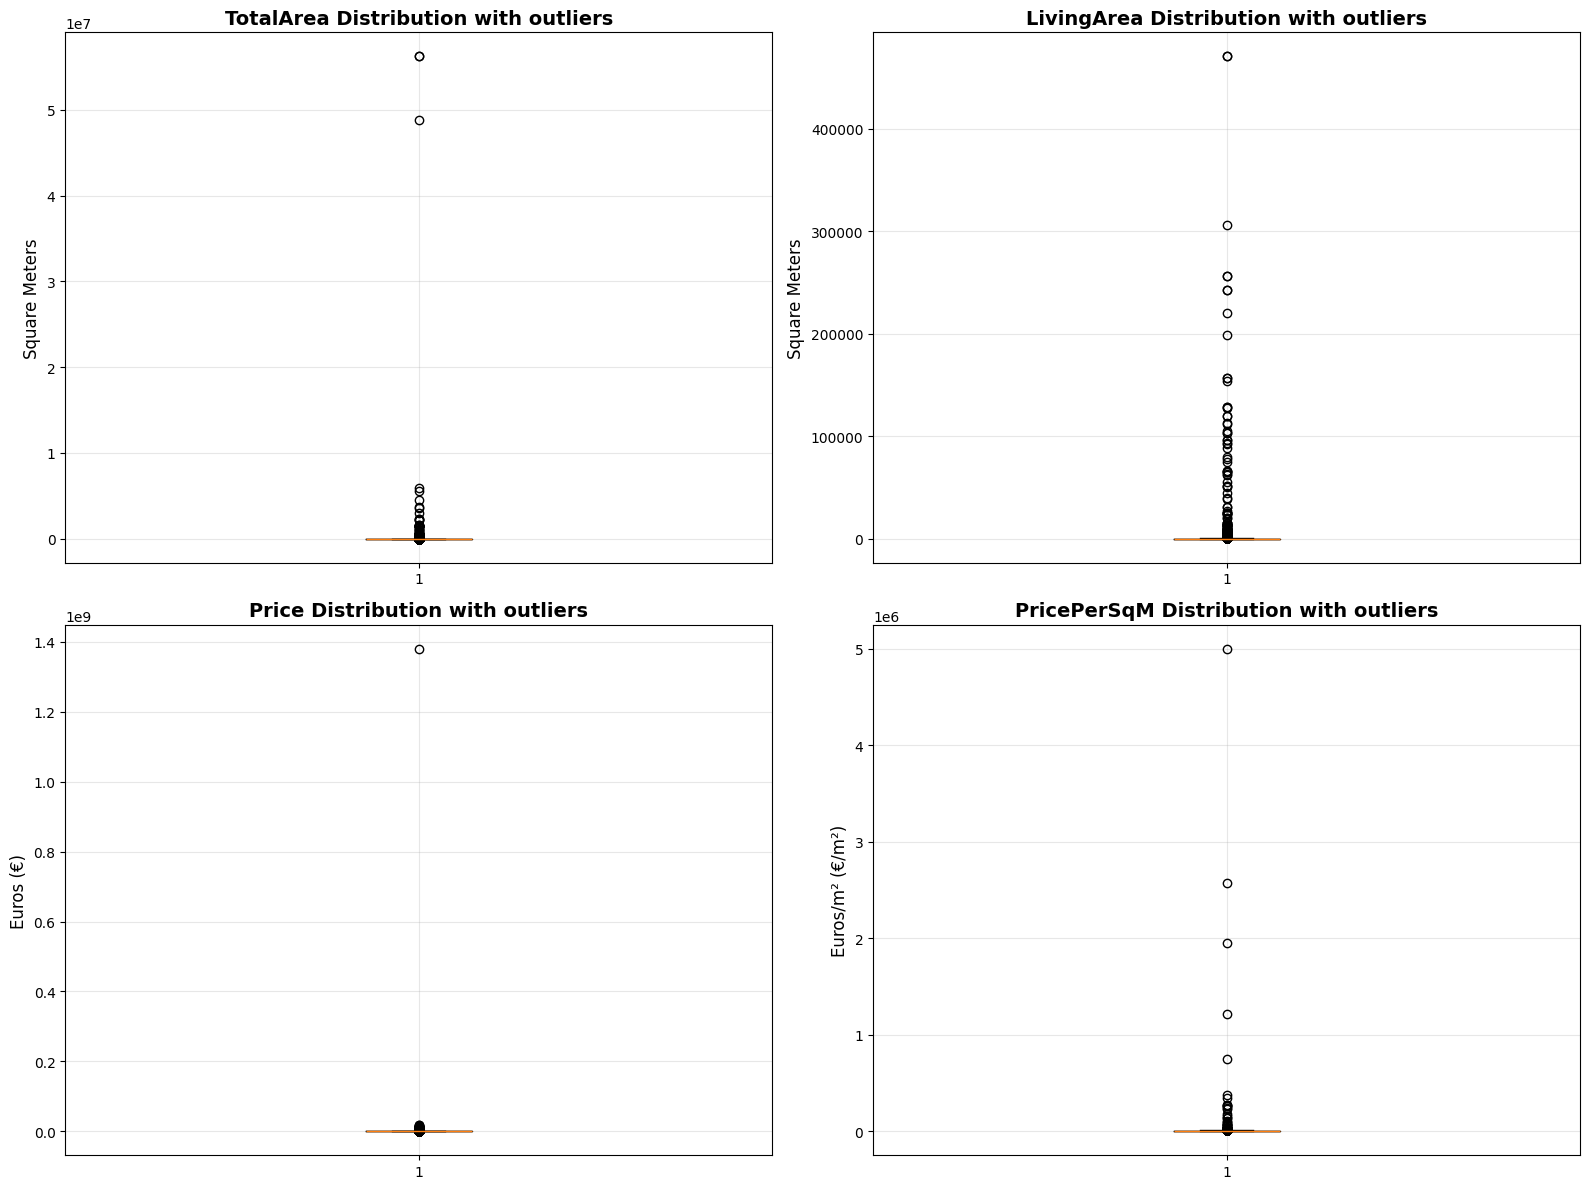

In [1019]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].boxplot(residential_dataset['TotalArea'].dropna())
axes[0, 0].set_title('TotalArea Distribution with outliers', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Square Meters', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot(residential_dataset['LivingArea'].dropna())
axes[0, 1].set_title('LivingArea Distribution with outliers', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Square Meters', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)


axes[1, 0].boxplot(residential_dataset['Price'].dropna())
axes[1, 0].set_title('Price Distribution with outliers', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Euros (€)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].boxplot(residential_dataset['PricePerSqM'].dropna())
axes[1, 1].set_title('PricePerSqM Distribution with outliers', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Euros/m² (€/m²)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The boxplot is the best to see this distribution, indeed, we have a __€1.4billion__ outlier that makes the price data not-readable. 
The best thing to do here is to delete it completely. 
We can then create some thresholds for the different features based on what could be reasonable for a residential real estate. 

In [1020]:
thresholds = {
    'TotalArea': (20, 1000),        
    'LivingArea': (15, 800),        
    'Price': (10000, 5000000),      
    'PricePerSqM': (100, 20000),    
    'TotalRestrooms': (0, 10),      
    'TotalLivingSpaces': (0, 15),   
}


Before will have our length of the current dataset.

In [1021]:
before = len(residential_dataset)

Now we can check the impact of these thresholds on our dataset.

In [1022]:
outliers_area_max = residential_dataset[residential_dataset['TotalArea'] > thresholds['TotalArea'][1]]
print(f"TotalArea > {thresholds['TotalArea'][1]}: {len(outliers_area_max):,} rows ({len(outliers_area_max)/before*100:.3f}%)")

outliers_area_min = residential_dataset[residential_dataset['TotalArea'] < thresholds['TotalArea'][0]]
print(f"TotalArea < {thresholds['TotalArea'][0]}: {len(outliers_area_min):,} rows ({len(outliers_area_min)/before*100:.3f}%)")

TotalArea > 1000: 4,493 rows (5.738%)
TotalArea < 20: 92 rows (0.117%)


In [1023]:
outliers_living_max = residential_dataset[residential_dataset['LivingArea'] > thresholds['LivingArea'][1]]
print(f"LivingArea > {thresholds['LivingArea'][1]}: {len(outliers_living_max):,} rows ({len(outliers_living_max)/before*100:.3f}%)")

outliers_living_min = residential_dataset[residential_dataset['LivingArea'] < thresholds['LivingArea'][0]]
print(f"LivingArea < {thresholds['LivingArea'][0]}: {len(outliers_living_min):,} rows ({len(outliers_living_min)/before*100:.3f}%)")

LivingArea > 800: 425 rows (0.543%)
LivingArea < 15: 227 rows (0.290%)


In [1024]:
outliers_price_min = residential_dataset[residential_dataset['Price'] < thresholds['Price'][0]]
print(f"Price < {thresholds['Price'][0]:,}: {len(outliers_price_min):,} rows ({len(outliers_price_min)/before*100:.3f}%)")

outliers_price_max = residential_dataset[residential_dataset['Price'] > thresholds['Price'][1]]
print(f"Price > {thresholds['Price'][1]:,}: {len(outliers_price_max):,} rows ({len(outliers_price_max)/before*100:.3f}%)")

Price < 10,000: 642 rows (0.820%)
Price > 5,000,000: 86 rows (0.110%)


In [1025]:
outliers_ppsm_max = residential_dataset[residential_dataset['PricePerSqM'] > thresholds['PricePerSqM'][1]]
print(f"PricePerSqM > {thresholds['PricePerSqM'][1]:,}: {len(outliers_ppsm_max):,} rows ({len(outliers_ppsm_max)/before*100:.3f}%)")

outliers_ppsm_min = residential_dataset[residential_dataset['PricePerSqM'] < thresholds['PricePerSqM'][0]]
print(f"PricePerSqM < {thresholds['PricePerSqM'][0]:,}: {len(outliers_ppsm_min):,} rows ({len(outliers_ppsm_min)/before*100:.3f}%)")

PricePerSqM > 20,000: 52 rows (0.066%)
PricePerSqM < 100: 2,936 rows (3.749%)


Now we regroup this all together in our __residential_clean__ dataset

In [1026]:
residential_clean = residential_dataset[
    (residential_dataset['TotalArea'] >= thresholds['TotalArea'][0]) &
    (residential_dataset['TotalArea'] <= thresholds['TotalArea'][1]) &
    (residential_dataset['LivingArea'] >= thresholds['LivingArea'][0]) &
    (residential_dataset['LivingArea'] <= thresholds['LivingArea'][1]) &
    (residential_dataset['Price'] >= thresholds['Price'][0]) &
    (residential_dataset['Price'] <= thresholds['Price'][1]) &
    (residential_dataset['PricePerSqM'] >= thresholds['PricePerSqM'][0]) &
    (residential_dataset['PricePerSqM'] <= thresholds['PricePerSqM'][1])
]

Now we can combine these filters. 

In [1027]:
total_removed = before - len(residential_clean)
print(f"Number of the total rows that we have removed -> {total_removed:,} ({total_removed/before*100:.3f}%)")
print(f"Number of the total rows still remaining -> {len(residential_clean):,} ({len(residential_clean)/before*100:.2f}%)")

Number of the total rows that we have removed -> 6,111 (7.804%)
Number of the total rows still remaining -> 72,197 (92.20%)


## Hypothesis Formulation - Residential Real Estate Price Drivers

Based on domain knowledge of real estate markets, I hypothesize the following relationships:

### **Hypotheses About Numeric Features:**

**H1: Size Metrics → Price**
- **H1a:** TotalArea is **positively correlated** with Price (larger properties cost more)
- **H1b:** LivingArea is **positively correlated** with Price
- **H1c:** The relationship might be **non-linear** (price per sqm decreases for very large properties)

**H2: Living Spaces → Price**
- **H2a:** TotalLivingSpaces (bedrooms) is **positively correlated** with Price
- **H2b:** TotalRestrooms is **positively correlated** with Price

**H3: Construction Year → Price**
- **H3:** ConstructionYear is **positively correlated** with Price (newer properties cost more)
- **Alternative:** Might be U-shaped (very old historic properties also valuable)

**H4: Multicollinearity**
- **H4:** TotalArea and LivingArea are **highly correlated** (potential multicollinearity issue)
- **H4b:** TotalLivingSpaces and TotalRestrooms are **correlated**


### **Success Criteria:**

- **Statistical Significance:** p-value < 0.05
- **Practical Significance:** 
  - Correlation: |r| > 0.3 (moderate), |r| > 0.5 (strong)
  - ANOVA eta-squared: η² > 0.06 (medium effect), η² > 0.14 (large effect)

In [1028]:
numeric_features = ['TotalArea', 'LivingArea', 'PricePerSqM', 'TotalRestrooms', 
                    'TotalLivingSpaces', 'ConstructionYear_Imputed']


correlations = residential_dataset[numeric_features + ['Price']].corr()['Price'].sort_values(ascending=False)

print("Pearson correalation with the price, which is our dependent variable:\n")
for feature in correlations.index:
    if feature != 'Price':
        corr_value = correlations[feature]
        
        if abs(corr_value) >= 0.7:
            strength = "good correlation"
        elif abs(corr_value) >= 0.5:
            strength = "ok, correlation"
        elif abs(corr_value) >= 0.3:
            strength = "MODERATE"
        else:
            strength = "ignore"
        
        direction = "positive" if corr_value > 0 else "negative"
        
        print(f"  {feature:30s}: {corr_value:+.4f}  ({strength} {direction})")

Pearson correalation with the price, which is our dependent variable:

  PricePerSqM                   : +0.4203  (MODERATE positive)
  TotalRestrooms                : +0.0446  (ignore positive)
  ConstructionYear_Imputed      : +0.0220  (ignore positive)
  TotalLivingSpaces             : +0.0056  (ignore positive)
  LivingArea                    : +0.0008  (ignore positive)
  TotalArea                     : +0.0007  (ignore positive)


Ok, so we have a just a few positive correlations with price without considering the `PricePerSqM`as it was created ad hoc from the `Price`itself. 

In [1029]:
for feature in numeric_features:
    mask = residential_dataset[[feature, 'Price']].notna().all(axis=1)
    x = residential_dataset.loc[mask, feature]
    y = residential_dataset.loc[mask, 'Price']
    
    corr, p_value = pearsonr(x, y)
    significance = "this feature is significant" if p_value < 0.05 else "this one is not significant"
    
    print(f"  {feature:30s}: p = {p_value:.6f}  {significance}")

  TotalArea                     : p = 0.839557  this one is not significant
  LivingArea                    : p = 0.829187  this one is not significant
  PricePerSqM                   : p = 0.000000  this feature is significant
  TotalRestrooms                : p = 0.000000  this feature is significant
  TotalLivingSpaces             : p = 0.116681  this one is not significant
  ConstructionYear_Imputed      : p = 0.000000  this feature is significant


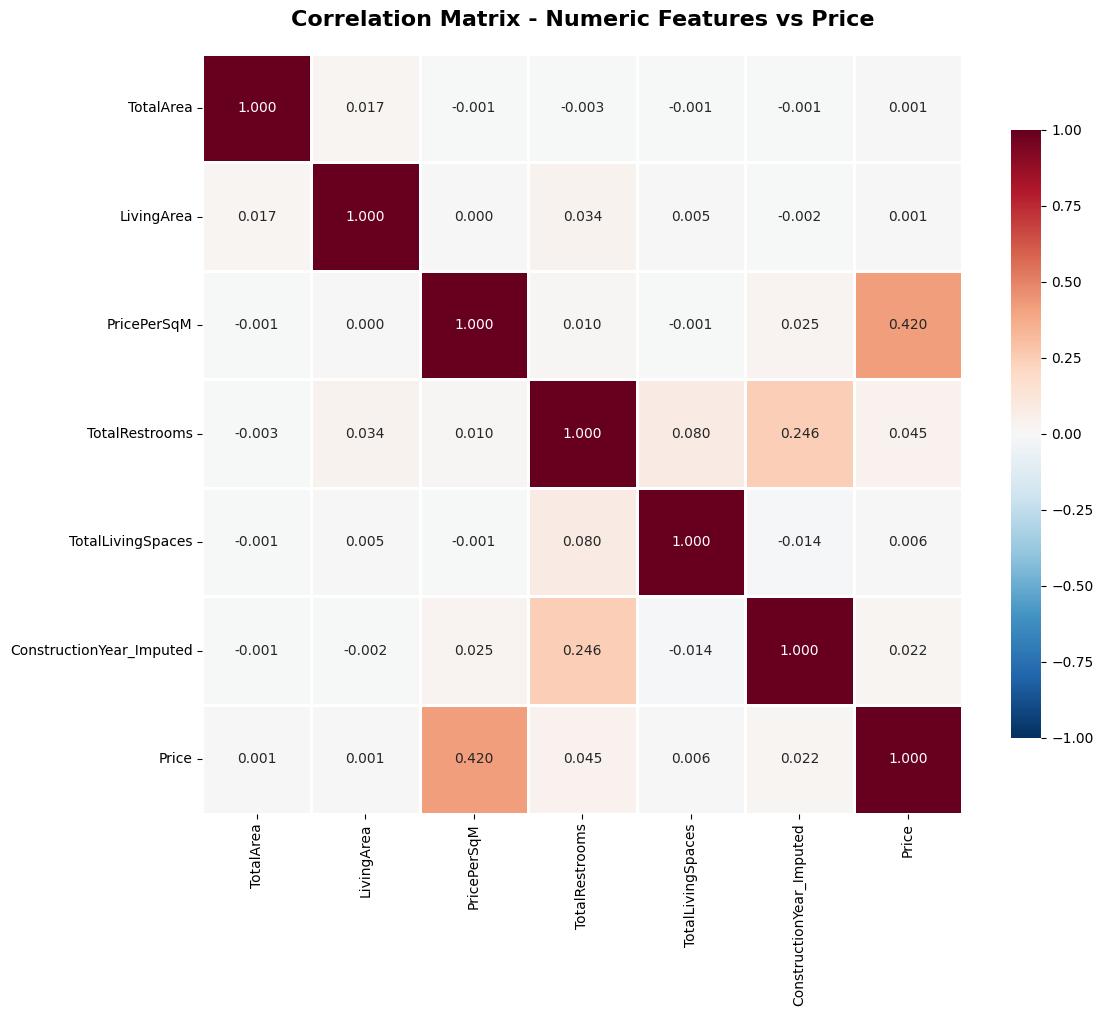

In [1030]:
fig, ax = plt.subplots(figsize=(12, 10))

correlation_matrix = residential_dataset[numeric_features + ['Price']].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix - Numeric Features vs Price', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

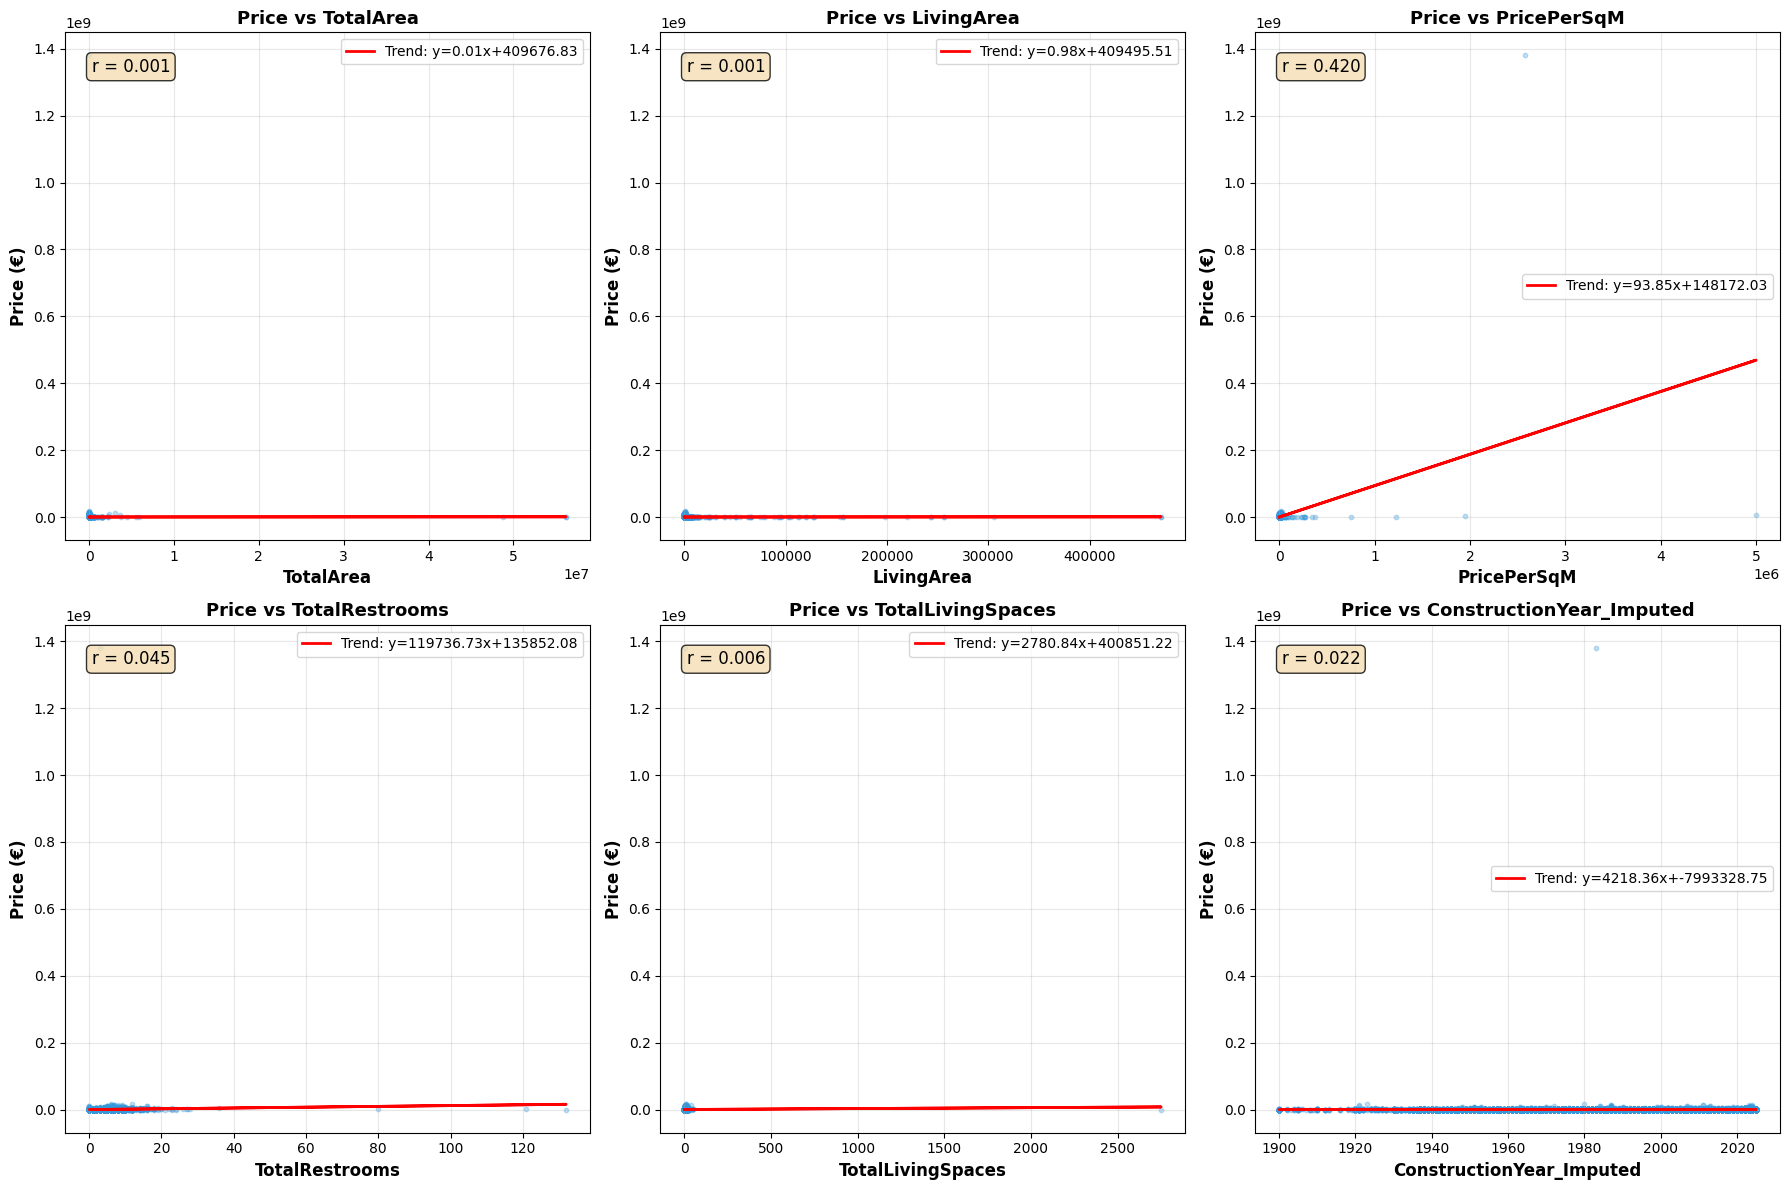

In [1031]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()


for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Remove NaN values
    mask = residential_dataset[[feature, 'Price']].notna().all(axis=1)
    x = residential_dataset.loc[mask, feature]
    y = residential_dataset.loc[mask, 'Price']
    
    
    ax.scatter(x, y, alpha=0.3, s=10, color='#3498db')
    
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r-", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    
    
    corr = correlations[feature]
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel(feature, fontsize=12, fontweight='bold')
    ax.set_ylabel('Price (€)', fontsize=12, fontweight='bold')
    ax.set_title(f'Price vs {feature}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

## Modeling 

In [1032]:
X = residential_dataset.drop(['Price', 'PricePerSqM', 'PropertySegment'], axis=1)
y = residential_dataset['Price']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

Before doing encoding, we should understand the cardinality in the categorical features: how many same values we have in our dataset. 

In [1033]:
for categorical_feature in x_categorical_residential:
    number_of_unique_values = residential_dataset[categorical_feature].nunique()
    print(f"{categorical_feature:30s}: {number_of_unique_values:4d} unique values")

District                      :   26 unique values
City                          :  271 unique values
Town                          : 2136 unique values
Type                          :    7 unique values
EnergyCertificate             :   11 unique values
PropertySegment               :    1 unique values
FloorSegment                  :    8 unique values
BuildingAge                   :    5 unique values


Typically, we use one __One Hot Encoding__ or __Label Encoding__, based on Cardinality:
- Low cardinality, means < 10 unique values, then we use __One-Hot Encoding__
- High cardinality, means ≥ 10 unique values, then we use __Label Encoding__

In [1034]:
x_categorical_residential.remove('PropertySegment')

low_cardinality_features = []
high_cardinality_features = []

for categorical_feature in x_categorical_residential:
    number_of_unique_values = X_train[categorical_feature].nunique()
    if number_of_unique_values < 10 : 
        low_cardinality_features.append(categorical_feature)
    else: 
        high_cardinality_features.append(categorical_feature)

Proceed with One-Hot Encoding

In [1035]:
X_train_processed = X_train.copy()
X_val_processed = X_val.copy()
X_test_processed = X_test.copy()

X_train_processed = pd.get_dummies(X_train_processed, columns = low_cardinality_features, drop_first = True, dtype = int)
X_val_processed = pd.get_dummies(X_val_processed, columns = low_cardinality_features, drop_first = True, dtype = int)
X_test_processed = pd.get_dummies(X_test_processed, columns = low_cardinality_features, drop_first = True, dtype = int)

In [1036]:
labels_by_label_encoding = {}

for feature in high_cardinality_features:
    label = LabelEncoder()
    
    
    X_train_processed[feature] = label.fit_transform(X_train[feature].astype(str))
    
    
    def safe_transform(series, encoder):
        
        return series.astype(str).map(
            lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1
        )
    
    X_val_processed[feature] = safe_transform(X_val[feature], label)
    X_test_processed[feature] = safe_transform(X_test[feature], label)
    
    labels_by_label_encoding[feature] = label

KeyboardInterrupt: 

## Training Random Forrest

In [ ]:
random_forrest_model = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

start_time = time.time()

random_forrest_model.fit(X_train_processed, y_train)
random_forrest_model_train_time = time.time() - start_time

y_predicted_random_forrest_model = random_forrest_model.predict(X_val_processed)

random_forest_mae = mean_absolute_error(y_val, y_predicted_random_forrest_model)
random_forest_rmse = np.sqrt(mean_squared_error(y_val, y_predicted_random_forrest_model))
random_forest_r2 = r2_score(y_val, y_predicted_random_forrest_model)

print(f"MAE is €{random_forest_mae:,.2f}")
print(f"RMSE is €{random_forest_rmse:,.2f}")
print(f"R² is {random_forest_r2:.4f}")
print(f"Time to train the model: {random_forrest_model_train_time:.2f}s")

MAE is €121,250.19
RMSE is €1,430,191.21
R² is -7.2085
Time to train the model: 4.08s


In [ ]:
gradient_boosting_model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)

start_time = time.time()

gradient_boosting_model.fit(X_train_processed, y_train)
gradient_boosting_train_time = time.time() - start_time

y_predicted_gradient_boosting = gradient_boosting_model.predict(X_val_processed)

gradient_boosting_mae = mean_absolute_error(y_val, y_predicted_gradient_boosting)
gradient_boosting_rmse = np.sqrt(mean_squared_error(y_val, y_predicted_gradient_boosting))
gradient_boosting_r2 = r2_score(y_val, y_predicted_gradient_boosting)

print(f"MAE is €{gradient_boosting_mae:,.2f}")
print(f"RMSE is €{gradient_boosting_rmse:,.2f}")
print(f"R² is {gradient_boosting_r2:.4f}")
print(f"Time to train the model: {gradient_boosting_train_time:.2f}s")

KeyboardInterrupt: 

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

start_time = time.time()

xgb_model.fit(X_train_processed, y_train)
xgb_model_train_time = time.time() - start_time

y_predicted_xgb_model = xgb_model.predict(X_val_processed)

xgb_model_mae = mean_absolute_error(y_val, y_predicted_xgb_model)
xgb_model_rmse = np.sqrt(mean_squared_error(y_val, y_predicted_xgb_model))
xgb_model_r2 = r2_score(y_val, y_predicted_xgb_model)

print(f"MAE is €{xgb_model_mae:,.2f}")
print(f"RMSE is €{xgb_model_rmse:,.2f}")
print(f"R² is {xgb_model_r2:.4f}")
print(f"Time to train the model: {xgb_model_train_time:.2f}s")

MAE is €123,770.72
RMSE is €1,088,512.68
R² is -3.7549
Time to train the model: 0.23s


In [ ]:
lgb_model = lgb.LGBMRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

start_time = time.time()

lgb_model.fit(X_train_processed, y_train)
lgb_model_train_time = time.time() - start_time

y_predicted_lgb_model = lgb_model.predict(X_val_processed)

lgb_model_mae = mean_absolute_error(y_val, y_predicted_lgb_model)
lgb_model_rmse = np.sqrt(mean_squared_error(y_val, y_predicted_lgb_model))
lgb_model_r2 = r2_score(y_val, y_predicted_lgb_model)

print(f"MAE is €{lgb_model_mae:,.2f}")
print(f"RMSE is €{lgb_model_rmse:,.2f}")
print(f"R² is {lgb_model_r2:.4f}")
print(f"Time to train the model: {lgb_model_train_time:.2f}s")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 46984, number of used features: 29
[LightGBM] [Info] Start training from score 420995.106206
MAE is €243,335.08
RMSE is €1,475,049.34
R² is -7.7315
Time to train the model: 0.44s


In [ ]:
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
    'MAE': [random_forest_mae, gradient_boosting_mae, xgb_model_mae, lgb_model_mae],
    'RMSE': [random_forest_rmse, gradient_boosting_rmse, xgb_model_rmse, lgb_model_rmse],
    'R²': [random_forest_r2, gradient_boosting_r2, xgb_model_r2, lgb_model_r2],
    'Train_Time_s': [random_forrest_model_train_time, gradient_boosting_train_time, xgb_model_train_time, lgb_model_train_time]
}).sort_values('R²', ascending=False)

print(comparison.to_string(index=False))

            Model       MAE       RMSE     R²  Train_Time_s
          XGBoost 123770.72 1088512.68  -3.75          0.23
    Random Forest 121250.19 1430191.21  -7.21          4.43
         LightGBM 243335.08 1475049.34  -7.73          0.44
Gradient Boosting 284863.62 2056518.60 -15.97          5.38


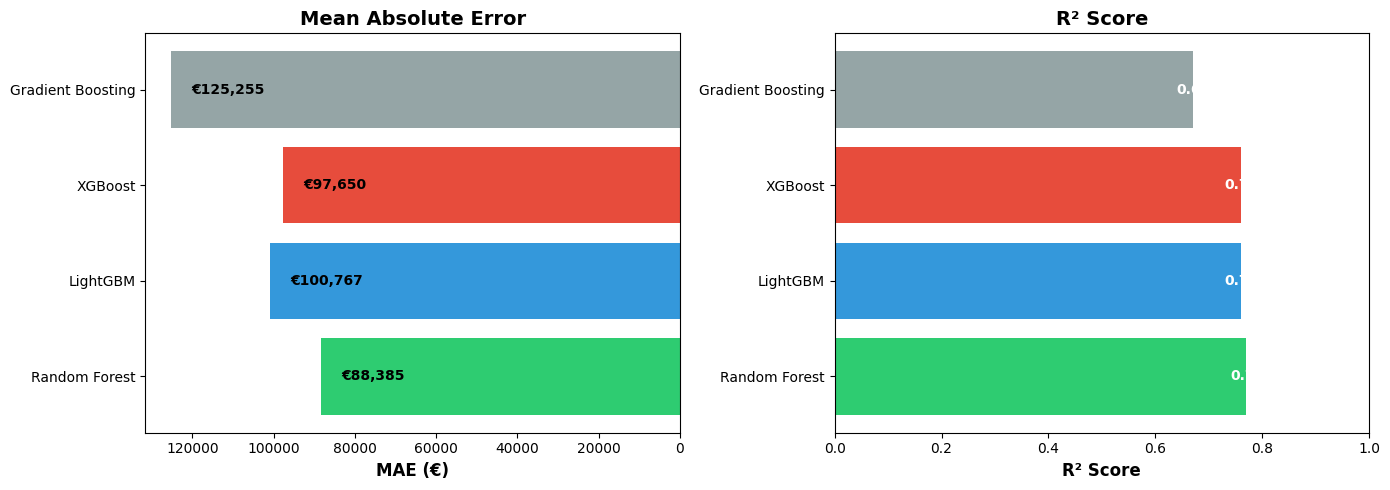

In [ ]:
models = ['Random Forest', 'LightGBM', 'XGBoost', 'Gradient Boosting']
mae_values = [88385.23, 100767.08, 97649.95, 125255.46]
r2_values = [0.77, 0.76, 0.76, 0.67]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(models, mae_values, color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
axes[0].set_xlabel('MAE (€)', fontsize=12, fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[0].invert_xaxis()  
for i, v in enumerate(mae_values):
    axes[0].text(v - 5000, i, f'€{v:,.0f}', va='center', fontweight='bold')

axes[1].barh(models, r2_values, color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
axes[1].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('R² Score', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
for i, v in enumerate(r2_values):
    axes[1].text(v - 0.03, i, f'{v:.2f}', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [ ]:
random_forest_parameter_space = {
    'n_estimators': Integer(100, 500), 
    'max_depth': Integer(10, 50), 
    'min_samples_split': Integer(2, 20), 
    'min_samples_leaf': Integer(1, 10), 
    'max_features': Real(0.3, 1.0)
}

random_forest_search = BayesSearchCV(
    RandomForestRegressor(random_state = 42, n_jobs = -1), 
    random_forest_parameter_space, 
    n_iter = 15, 
    cv = 3, 
    scoring = 'neg_mean_absolute_error', 
    random_state = 42, 
    n_jobs = -1, 
    verbose = 1
)

random_forest_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [ ]:
print(f"Best Random Forest parameters: {random_forest_search.best_params_}")

Best Random Forest parameters: OrderedDict([('max_depth', 43), ('max_features', 0.9669133553749512), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 284)])


Now we can evaluate on the Validation dataset

In [ ]:
y_predicted_random_forest_tuned = random_forest_search.predict(X_val_processed)
random_forest_tuned_mae = mean_absolute_error(y_val, y_predicted_random_forest_tuned)
random_forest_tuned_rmse = np.sqrt(mean_squared_error(y_val, y_predicted_random_forest_tuned))
random_forest_tuned_r2 = r2_score(y_val, y_predicted_random_forest_tuned)

In [ ]:
print(f"Tuned Random Forrest MAE is €{random_forest_tuned_mae:,.2f}, when baseline was {random_forest_mae:,.2f}")
print(f"Tuned RMSE is €{random_forest_tuned_rmse:,.2f}, when baseline was {random_forest_rmse:,.2f}")
print(f"Tuned R² is €{random_forest_tuned_r2:.4f}, when baseline was {random_forest_r2:,.4f}")

Tuned Random Forrest MAE is €88,246.65, when baseline was 88,385.23
Tuned RMSE is €216,763.44, when baseline was 217,882.06
Tuned R² is €0.7748, when baseline was 0.7724


In [ ]:
xgb_parameter_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0, 1.0),
    'reg_lambda': Real(0, 1.0)
}

xgb_search = BayesSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    xgb_parameter_space,
    n_iter=30,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

,estimator,"XGBRegressor(...ree=None, ...)"
,search_spaces,"{'colsample_bytree': Real(low=0.6,...m='normalize'), 'learning_rate': Real(low=0.01...m='normalize'), 'max_depth': Integer(low=3...m='normalize'), 'n_estimators': Integer(low=1...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,30
,scoring,'neg_mean_absolute_error'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [ ]:
print(f"Best Random Forest parameters: {xgb_search.best_params_}")

Best Random Forest parameters: OrderedDict([('colsample_bytree', 0.6), ('learning_rate', 0.06331863235215066), ('max_depth', 10), ('n_estimators', 500), ('reg_alpha', 1.0), ('reg_lambda', 0.9058609781905336), ('subsample', 0.9670719912361456)])


In [ ]:
y_predicted_xgb_tuned = xgb_search.predict(X_val_processed)
xgb_tuned_mae = mean_absolute_error(y_val, y_predicted_xgb_tuned)
xgb_tuned_rmse = np.sqrt(mean_squared_error(y_val, y_predicted_xgb_tuned))
xgb_tuned_r2 = r2_score(y_val, y_predicted_xgb_tuned)

print(f"Tuned XGB  MAE is €{xgb_tuned_mae:,.2f}, when baseline was {xgb_model_mae:,.2f}")
print(f"Tuned XGB RMSE is €{xgb_tuned_rmse:,.2f}, when baseline was {xgb_model_rmse:,.2f}")
print(f"Tuned XGB R² is €{xgb_tuned_r2:.4f}, when baseline was {xgb_model_r2:,.4f}")

Tuned XGB  MAE is €78,740.65, when baseline was 97,649.95
Tuned XGB RMSE is €206,282.15, when baseline was 224,927.97
Tuned XGB R² is €0.7960, when baseline was 0.7575


In [ ]:
comparison = pd.DataFrame({
    'Model': ['Random Forest Tuned', 'XGB Boost Tuned'],
    'MAE': [random_forest_tuned_mae, xgb_tuned_mae],
    'RMSE': [random_forest_tuned_rmse, xgb_tuned_rmse],
    'R²': [random_forest_tuned_r2, xgb_tuned_r2]
}).sort_values('R²', ascending=False)

print(comparison.to_string(index=False))

              Model      MAE      RMSE   R²
    XGB Boost Tuned 78740.65 206282.15 0.80
Random Forest Tuned 88246.65 216763.44 0.77


## Applying SHAP for model Explainability

In [ ]:
background = shap.sample(X_train_processed, 100)

explainer = shap.Explainer(
    xgb_search.best_estimator_.predict, 
    background
)

sample_size = min(500, len(X_val_processed))
X_val_sample = X_val_processed.iloc[:sample_size]

shap_values = explainer.shap_values(X_val_sample)

PermutationExplainer explainer: 501it [00:46,  9.42it/s]                         


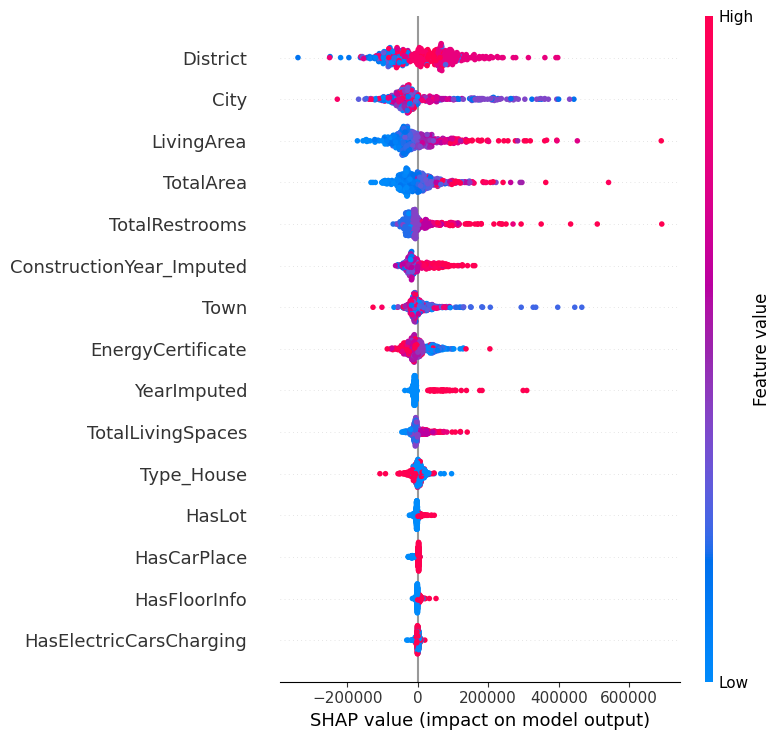

In [ ]:
shap.summary_plot(shap_values, X_val_sample, max_display=15)

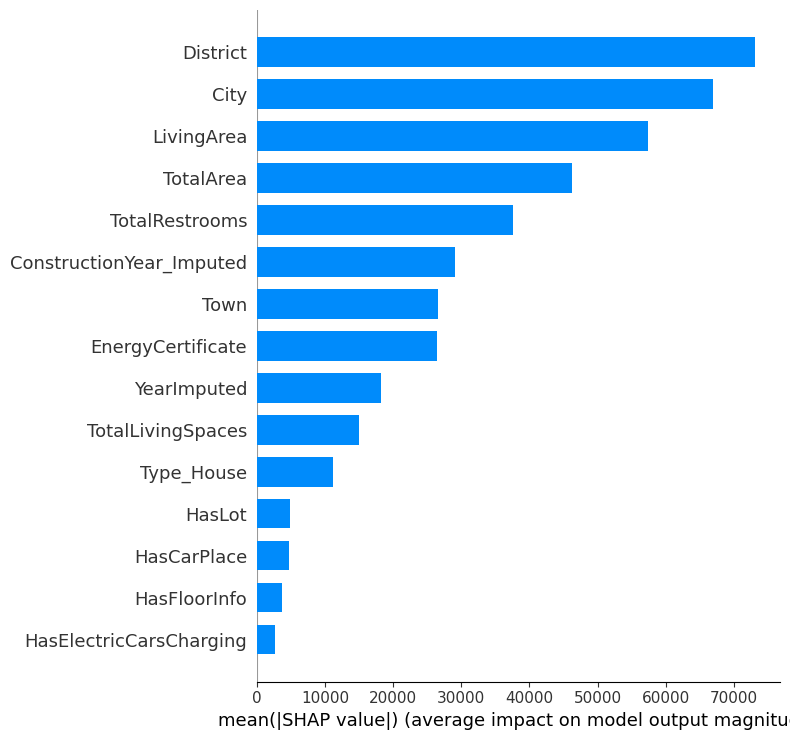

In [ ]:
shap.summary_plot(shap_values, X_val_sample, plot_type="bar", max_display=15)

## Let's use our best model tuned on the Test dataset

By using __get_dummies()__ we encounter an error as following the creation of __X_train_processed__ and then __X_test_processed__: 
get_dummies() created a "Type_Manor" column in the train dataset, but not in the test dataset. 

In [ ]:
missing_columns = set(X_train_processed.columns) - set(X_test_processed.columns)
for columns in missing_columns:
    X_test_processed[columns] = 0

X_test_processed = X_test_processed[X_train_processed.columns]

Now we can train it

In [ ]:
y_predicted_test = xgb_search.predict(X_test_processed)

Calculating performance indicators

test_xgb_mae = mean_absolute_error(y_test, y_predicted_test)
test_xgb_rmse = np.sqrt(mean_squared_error(y_test, y_predicted_test))
test_xgb_r2 = r2_score(y_test, y_predicted_test)

print(f"MAE for the test set on XBG Tuned is €{test_xgb_mae:,.2f}")
print(f"RMSE for the test set on XBG Tuned is €{test_xgb_rmse:,.2f}")
print(f"R² for the test set on XBG Tuned is €{test_xgb_r2:.4f}")

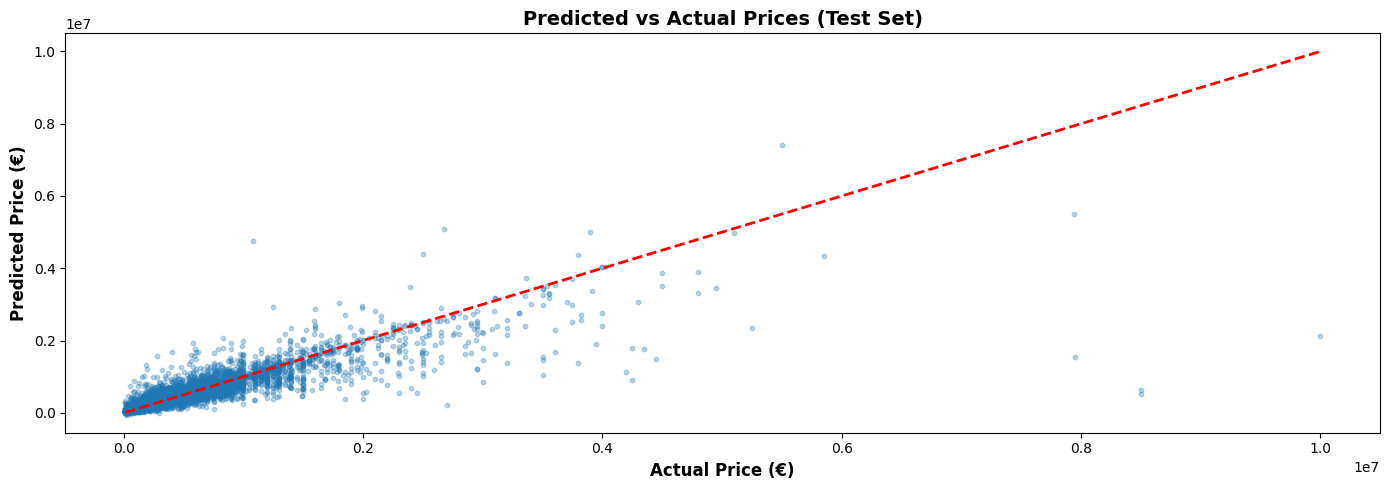

In [ ]:
fig, axes = plt.subplots(figsize=(14, 5))

axes.scatter(y_test, y_predicted_test, alpha=0.3, s=10)
axes.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes.set_xlabel('Actual Price (€)', fontsize=12, fontweight='bold')
axes.set_ylabel('Predicted Price (€)', fontsize=12, fontweight='bold')
axes.set_title('Predicted vs Actual Prices (Test Set)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Now we can save out model!


In [ ]:
feature_names = X_train_processed.columns.tolist()

preprocessing_info = {
    'low_cardinality_features': low_cardinality_features,
    'high_cardinality_features': high_cardinality_features,
    'dropped_features': ['Price', 'PricePerSqM', 'PropertySegment']
}

In [ ]:
joblib.dump(xgb_search.best_estimator_, 'xgboost_model.pkl')
joblib.dump(labels_by_label_encoding, 'label_encoders.pkl')
joblib.dump(feature_names, 'feature_names.pkl')
joblib.dump(preprocessing_info, 'preprocessing_info.pkl')

['preprocessing_info.pkl']

In [ ]:
for f in ['xgboost_model.pkl', 'label_encoders.pkl', 'feature_names.pkl', 'preprocessing_info.pkl']:
    exists = "This file is good and ready:" if os.path.exists(f) else "This file is not:"
    print(f"{exists} {f}")

This file is good and ready: xgboost_model.pkl
This file is good and ready: label_encoders.pkl
This file is good and ready: feature_names.pkl
This file is good and ready: preprocessing_info.pkl


In [ ]:

print("FloorSegment values:")
print(residential_dataset['FloorSegment'].unique())

print("\nBuildingAge values:")
print(residential_dataset['BuildingAge'].unique())

print("\nType values:")
print(residential_dataset['Type'].unique())

print("\nEnergyCertificate values:")
print(residential_dataset['EnergyCertificate'].unique())

FloorSegment values:
['Ground Floor' 'Low - 1st' 'Mid 2nd-5th' 'Other' 'Very High 10+'
 'High 6th-9th' 'Multi-Level' 'Attic']

BuildingAge values:
['Brand New (2020+)' 'Mid-age (1990-2009)' 'Old (1950-1989)'
 'Vintage (pre-1950)' 'Recent (2010-2019)']

Type values:
['Apartment' 'House' 'Other - Residential' 'Duplex' 'Studio' 'Mansion'
 'Manor']

EnergyCertificate values:
['A+' 'C' 'D' 'NC' 'B' 'A' 'B-' 'E' 'F' 'G' 'No Certificate']
